# Cell Segmentation

In [2]:
#!/usr/bin/env python3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Tuple, Dict

from evaluation_tasks import evaluate_cell_benchmark

# ---------------- cfg ----------------
thr = np.arange(0.50, 0.96, 0.05)
ap_cols = [f"AP@{t:.2f}" for t in thr]
cyto_preds: Dict[str, Path] = {
    "Cellpose":  Path("/ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/refilter_outputs/feat-mean_thr-otsu_area-100_gate-off"),
    "Cellpose Unrefined":  Path("/ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/cyto_prediction"),
    "StarDist":  Path("/ihome/jbwang/liy121/ifimage/02_stardist_benchmark/refilter_outputs/feat-mean_thr-otsu_area-100_gate-off"),
    "CellSAM":   Path("/ihome/jbwang/liy121/ifimage/03_cellsam_benchmark/refilter_outputs/feat-mean_thr-otsu_area-100_gate-off"),
    "MESMER":    Path("/ihome/jbwang/liy121/ifimage/04_mesmer_benchmark/refilter_outputs/feat-mean_thr-otsu_area-100_gate-off"),
    "Watershed": Path("/ihome/jbwang/liy121/ifimage/06_watershed_benchmark/refilter_outputs/feat-mean_thr-otsu_area-100_gate-off"),
    "Omnipose":  Path("/ihome/jbwang/liy121/ifimage/07_omnipose_benchmark/refilter_outputs/feat-mean_thr-otsu_area-100_gate-off"),
    "Lacss":     Path("/ihome/jbwang/liy121/ifimage/011_lacss/refilter_outputs/feat-mean_thr-otsu_area-100_gate-off"),
    "HoVerNet":  Path("/ihome/jbwang/liy121/ifimage/09_hovernet_benchmark/refilter_outputs/feat-mean_thr-otsu_area-100_gate-off"),
    "SplineDist":Path("/ihome/jbwang/liy121/ifimage/08_splinedist_benchmark/refilter_outputs/feat-mean_thr-otsu_area-100_gate-off"),
}
dataset_dir = "/ihome/jbwang/liy121/ifimage/00_dataset_withoutpecam"
out_dir = Path("/ihome/jbwang/liy121/ifimage/plots")
boundary_scales: Tuple[float, ...] = (1.0, 2.0)
ap_thresholds: Tuple[float, ...] = tuple(np.round(thr, 2))
out_dir.mkdir(parents=True, exist_ok=True)

# ------------- cache helpers -------------
def _sig_name(cyto_pred_dirs: Dict[str, Path],
              ap_thresholds: Tuple[float, ...],
              boundary_scales: Tuple[float, ...]) -> str:
    algos = "-".join(sorted(cyto_pred_dirs.keys()))
    thr_s = "_".join(f"{t:.2f}" for t in ap_thresholds)
    bnd_s = "_".join(f"{b:.1f}" for b in boundary_scales)
    return f"cyto__algos={algos}__thr={thr_s}__bnd={bnd_s}"

def _candidate_paths(out_root: Path, sig: str):
    per_img_csv = out_root / f"{sig}__per_img.csv"
    sum_csv     = out_root / f"{sig}__summary.csv"
    per_img_par = out_root / f"{sig}__per_img.parquet"
    sum_par     = out_root / f"{sig}__summary.parquet"
    return (per_img_csv, sum_csv, per_img_par, sum_par)

def _read_first_existing(per: Path, summ: Path, per_par: Path, summ_par: Path):
    if per.exists() and summ.exists():
        return pd.read_csv(per), pd.read_csv(summ)
    if per_par.exists() and summ_par.exists():
        return pd.read_parquet(per_par), pd.read_parquet(summ_par)
    return None, None

def _save_both(per_img: pd.DataFrame, summary: pd.DataFrame, per: Path, summ: Path, per_par: Path, summ_par: Path):
    per_img.to_csv(per, index=False)
    summary.to_csv(summ, index=False)
    per_img.to_parquet(per_par, index=False)
    summary.to_parquet(summ_par, index=False)

# ------------- load-or-run -------------
sig = _sig_name(cyto_preds, ap_thresholds, boundary_scales)
per_csv, sum_csv, per_par, sum_par = _candidate_paths(out_dir, sig)
per_img_cyto, sum_cyto = _read_first_existing(per_csv, sum_csv, per_par, sum_par)

if per_img_cyto is None or sum_cyto is None:
    per_img_cyto, sum_cyto = evaluate_cell_benchmark(
        dataset_dir=dataset_dir,
        cyto_pred_dirs=cyto_preds,
        ap_thresholds=ap_thresholds,
        boundary_scales=boundary_scales,
        max_workers=4,
        out_dir=str(out_dir),
        verbose=True,
    )
    _save_both(per_img_cyto, sum_cyto, per_csv, sum_csv, per_par, sum_par)

# ------------- curve + plot -------------
ap_cols_present = [c for c in ap_cols if c in per_img_cyto.columns]
curve = per_img_cyto.groupby("algorithm")[ap_cols_present].mean()
mAP = curve.mean(axis=1)

print("[PLOT] algorithms:", list(curve.index))
print("[PLOT] AP columns:", ap_cols_present)
print("[PLOT] mAP sorted:\n", mAP.sort_values(ascending=False))


[PLOT] algorithms: ['CellSAM', 'Cellpose', 'Cellpose Unrefined', 'HoVerNet', 'Lacss', 'MESMER', 'Omnipose', 'SplineDist', 'StarDist', 'Watershed']
[PLOT] AP columns: ['AP@0.50', 'AP@0.55', 'AP@0.60', 'AP@0.65', 'AP@0.70', 'AP@0.75', 'AP@0.80', 'AP@0.85', 'AP@0.90', 'AP@0.95']
[PLOT] mAP sorted:
 algorithm
Cellpose              0.207577
Lacss                 0.191322
SplineDist            0.161616
CellSAM               0.131384
MESMER                0.119536
Watershed             0.105755
StarDist              0.099528
Omnipose              0.093547
Cellpose Unrefined    0.050340
HoVerNet              0.000000
dtype: float64


Saved:
  /ihome/jbwang/liy121/ifimage/plots/cell_AP_vs_IoU_overall.pdf
  /ihome/jbwang/liy121/ifimage/plots/cell_AP_vs_IoU_overall.png


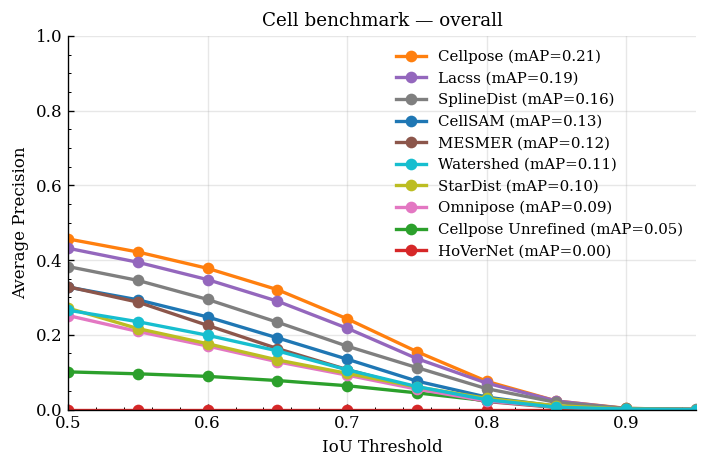

In [3]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
try:
    plt.style.use(['science', 'no-latex'])
except Exception:
    mpl.rcParams.update({
        "font.family": "Arial",
        "font.size": 10,
        "axes.titlesize": 11,
        "axes.labelsize": 10,
        "legend.fontsize": 9,
        "xtick.direction": "in",
        "ytick.direction": "in",
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
        "grid.alpha": 0.3,
        "grid.linestyle": "-",
        "savefig.bbox": "tight",
        "figure.dpi": 120,
    })

if curve.empty:
    raise ValueError("`curve` is empty. Did per_img_cyto/groupby succeed?")
if 'mAP' not in locals():
    mAP = curve.mean(axis=1)

# ------------- PLOT -------------
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)


line_by_algo = {}
for algo, row in curve.iterrows():
    ln, = ax.plot(thr, row.values, marker='o', linewidth=2,
                  label=f"{algo} (mAP={mAP[algo]:.02f})")
    line_by_algo[algo] = ln

ax.set_title("Cell benchmark — overall")
ax.set_xlabel("IoU Threshold")
ax.set_ylabel("Average Precision")
ax.set_xlim(thr.min(), thr.max())
ax.set_ylim(0, 1.0)
ax.minorticks_on()
ax.grid(alpha=0.3)

# ------------- LEGEND: sort high → low by mAP -------------
sorted_algos = sorted(mAP.index, key=lambda k: mAP[k], reverse=True)
handles = [line_by_algo[a] for a in sorted_algos]
labels  = [f"{a} (mAP={mAP[a]:.02f})" for a in sorted_algos]
ax.legend(handles, labels, frameon=False)

plt.tight_layout()

# ------------- SAVE FIGURES -------------
# Respect your earlier out_dir if defined; else fall back to ./figs
try:
    # `out_dir` was passed to evaluate_cell_benchmark; reuse it if present
    out_dir = Path(out_dir)  # may already be a Path or str in your session
except NameError:
    out_dir = Path("./figs")

out_dir.mkdir(parents=True, exist_ok=True)
pdf_path = out_dir / "cell_AP_vs_IoU_overall.pdf"
png_path = out_dir / "cell_AP_vs_IoU_overall.png"

fig.savefig(pdf_path, format="pdf", transparent=True)
fig.savefig(png_path, format="png", dpi=300, transparent=True)

print(f"Saved:\n  {pdf_path}\n  {png_path}")

plt.show()

## Best Each

[SAVED] plots/best_per_celltype_report_3x4_whitebg.png
[SAVED] plots/best_per_celltype_report_3x4_whitebg.pdf


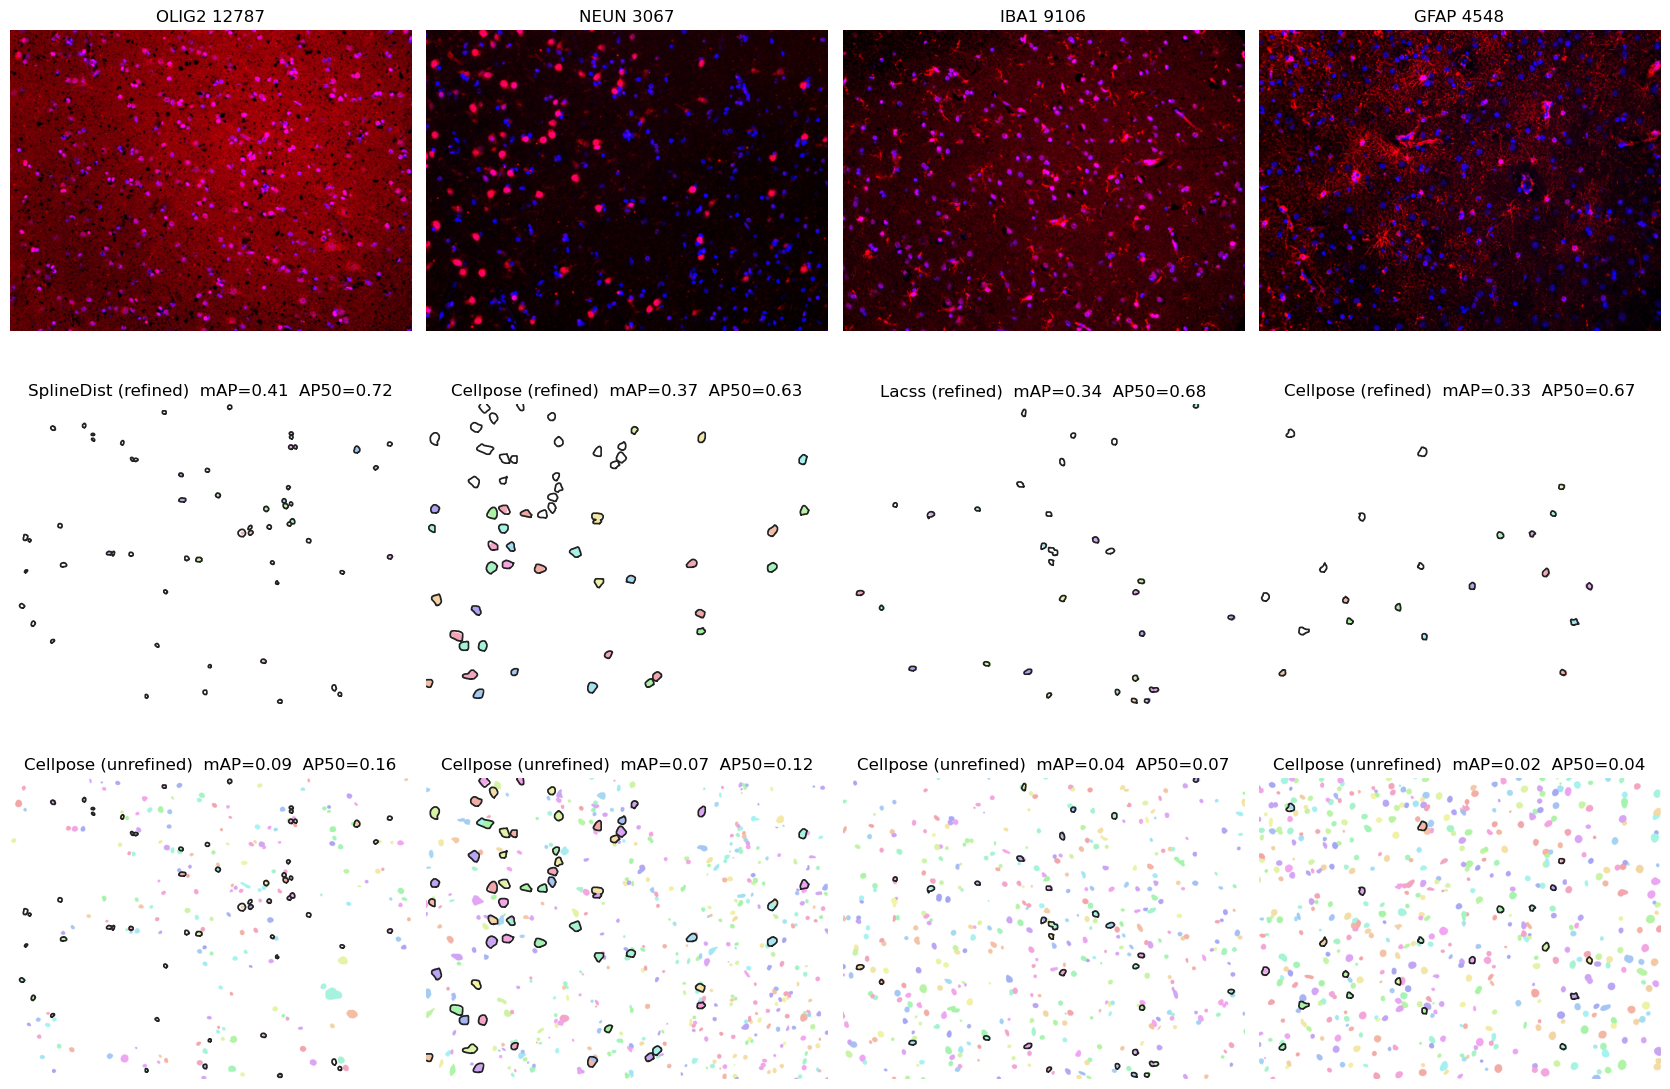

In [5]:
# All comments in ENGLISH
from pathlib import Path
import re, math, hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile as tiff
from skimage.measure import find_contours

# -------- CONFIG --------
PER_IMG = per_img_cyto
DATASET_DIR = Path("/ihome/jbwang/liy121/ifimage/00_dataset_withoutpecam")
PRED_REFINED_ROOT   = Path("/ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/cyto_prediction_refined_mean_otsu_area100")
PRED_UNREFINED_ROOT = Path("/ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/cyto_prediction")
GROUPS = {"OLIG2": r"OLIG2", "NEUN": r"NEUN", "IBA1": r"IBA1", "GFAP": r"GFAP"}
OUT_PNG = Path("plots/best_per_celltype_report_3x4_whitebg.png")
OUT_PDF = Path("plots/best_per_celltype_report_3x4_whitebg.pdf")
BOUNDARY_W = 1.2
FILL_ALPHA = 0.92  # stronger fills on white

# -------- IO / IMAGE UTILS --------
def _load_any(p: Path) -> np.ndarray:
    return np.load(p) if p.suffix.lower()==".npy" else np.squeeze(tiff.imread(str(p)))

def _to_gray(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x)
    if x.ndim == 3:
        x = (0.2126*x[...,0] + 0.7152*x[...,1] + 0.0722*x[...,2]) if x.shape[-1] >= 3 else x.max(-1)
    elif x.ndim > 2:
        x = x.squeeze()
        if x.ndim > 2: x = x.max(0)
    return x.astype(np.float32)

def _norm01(x: np.ndarray) -> np.ndarray:
    if x.size == 0: return x.astype(np.float32)
    p1, p99 = np.percentile(x, [1, 99])
    if p99 <= p1:
        mn, mx = float(x.min()), float(x.max())
        if mx <= mn: return np.zeros_like(x, np.float32)
        p1, p99 = mn, mx
    return np.clip((x - p1) / max(p99 - p1, 1e-6), 0, 1).astype(np.float32)

def _first_match(root: Path, pats) -> Path | None:
    for pat in pats:
        hit = next(root.glob(pat), None)
        if hit is not None: return hit
    return None

def find_raw_channels(base: str):
    lead = base.split("_", 1)[0].lower()
    dapi_fp = _first_match(DATASET_DIR, [f"{base}.tif", f"{base}.tiff", f"{base}.npy",
                                         f"{base}_dapi.tif", f"{base}_dapi.tiff", f"{base}_dapi.npy"])
    marker_fp = _first_match(DATASET_DIR, [f"{base}_{lead}.tif", f"{base}_{lead}.tiff", f"{base}_{lead}.npy",
                                           f"{base}_marker.tif", f"{base}_marker.tiff", f"{base}_marker.npy"])
    d = _load_any(dapi_fp) if dapi_fp else None
    m = _load_any(marker_fp) if marker_fp else None
    return d, m

def make_composite(dapi, marker):
    # DAPI -> blue, Marker -> red
    if dapi is None and marker is None: return None
    d = _to_gray(dapi) if dapi is not None else None
    m = _to_gray(marker) if marker is not None else None
    if d is not None and m is not None:
        h, w = min(d.shape[0], m.shape[0]), min(d.shape[1], m.shape[1])
        d, m = d[:h,:w], m[:h,:w]
    base = d if d is not None else m
    H, W = base.shape
    rgb = np.zeros((H, W, 3), np.float32)
    if d is not None: rgb[...,2] = _norm01(d)  # blue
    if m is not None: rgb[...,0] = _norm01(m)  # red
    return rgb

def stack_to_label(arr):
    if arr.ndim == 3:
        lab = np.zeros(arr.shape[1:], np.int32); k = 0
        for i in range(arr.shape[0]):
            m = arr[i] > 0
            if m.any(): k += 1; lab[m] = k
        return lab
    return arr

def find_gt(base):
    p = DATASET_DIR / f"{base}_cellbodies.npy"
    return p if p.exists() else next(DATASET_DIR.rglob(f"{base}*cellbodies*.npy"), None)

def find_pred(base, root: Path):
    p = root / f"{base}_pred_cyto.npy"
    return p if p.exists() else next(root.rglob(f"{base}*pred*cyto*.npy"), None)

# -------- PRETTY MASK RENDERING ON WHITE --------
def _seed_from_text(s: str) -> int:
    return int(hashlib.sha256(s.encode()).hexdigest()[:8], 16)

def _pastel_palette(n: int, seed: int):
    rng = np.random.default_rng(seed)
    hues = rng.random(n)
    S, V = 0.35, 0.95
    rgb = []
    for h in hues:
        i = int(h*6.0) % 6; f = h*6.0 - i
        p = V*(1-S); q = V*(1-S*f); t = V*(1-S*(1-f))
        if   i==0: r,g,b = V,t,p
        elif i==1: r,g,b = q,V,p
        elif i==2: r,g,b = p,V,t
        elif i==3: r,g,b = p,q,V
        elif i==4: r,g,b = t,p,V
        else:      r,g,b = V,p,q
        rgb.append((r,g,b))
    return np.array(rgb, dtype=np.float32)

def label_viz_on_white(lab: np.ndarray, *, seed_text: str, fill_alpha: float = FILL_ALPHA) -> np.ndarray:
    H, W = lab.shape[:2]
    img = np.ones((H, W, 3), np.float32)
    ids = [i for i in np.unique(lab) if i != 0]
    if not ids: return img
    pal = _pastel_palette(len(ids), _seed_from_text(seed_text))
    id2idx = {i:k for k,i in enumerate(ids)}
    for i in ids:
        m = (lab == i)
        if not m.any(): continue
        c = pal[id2idx[i]]
        img[m] = img[m]*(1-fill_alpha) + c*fill_alpha
    return img

def draw_contours(ax, binary, color="k", lw=1.1):
    for cnt in find_contours(binary.astype(float), 0.5):
        ax.plot(cnt[:,1], cnt[:,0], color=color, linewidth=lw, solid_capstyle="round")

# -------- TABLE --------
def as_df(x):
    if isinstance(x, dict):
        parts = []
        for algo, df in x.items():
            if df is None or df.empty: continue
            dfx = df.copy(); dfx["algorithm"] = algo; parts.append(dfx)
        return pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()
    return x.copy()

def infer_ap_cols(df):
    ap = [c for c in df.columns if re.match(r"^AP@\d\.\d{2}$", c)]
    if not ap: raise ValueError("No AP@xx.xx columns found.")
    return sorted(ap, key=lambda c: float(c.split("@")[1]))

def per_image_scores(df: pd.DataFrame, base: str, algo: str):
    ap_cols = infer_ap_cols(df)
    sub = df[(df["base"] == base) & (df["algorithm"] == algo)]
    if sub.empty: return np.nan, np.nan
    r = sub.iloc[0]
    mAP = pd.to_numeric(r[ap_cols], errors="coerce").mean()
    ap50 = float(r.get("AP@0.50", np.nan))
    return float(mAP), ap50

df = as_df(PER_IMG)
if "base" not in df.columns: raise ValueError("Missing 'base'")
if "algorithm" not in df.columns: df["algorithm"] = "model"
ap_cols = infer_ap_cols(df)
df["_score"] = pd.to_numeric(df[ap_cols].mean(axis=1), errors="coerce")
df = df.dropna(subset=["_score"])

best = []
for gname, pat in GROUPS.items():
    sub = df[df["base"].str.contains(pat, case=False, regex=True, na=False)]
    best.append((gname, None if sub.empty else sub.loc[sub["_score"].idxmax()]))

# -------- FIGURE 3x4 --------
cols = list(GROUPS.keys()); ncols = len(cols); nrows = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(4.2*ncols, 3.9*nrows), squeeze=False)

for j, (gname, row) in enumerate(best):
    ax_raw, ax_ref, ax_unr = axes[0, j], axes[1, j], axes[2, j]

    if row is None:
        for ax in (ax_raw, ax_ref, ax_unr): ax.axis("off")
        ax_raw.set_title(f"{gname}: no image"); continue

    base = str(row["base"]); algo = str(row.get("algorithm", "model"))
    score = float(row["_score"]); ap50_ref = float(row.get("AP@0.50", np.nan))

    # row 1: raw composite
    comp = make_composite(*find_raw_channels(base))
    if comp is None:
        ax_raw.axis("off"); ax_raw.set_title(f"{gname} | {base}\nraw missing", fontsize=9)
    else:
        ax_raw.imshow(comp)
        pretty_base = base.replace("_", " ").upper()
        ax_raw.set_title(f"{pretty_base}", fontsize=12)
        ax_raw.axis("off")

    # GT
    gt_path = find_gt(base)
    if gt_path is None or not gt_path.exists():
        for ax, tag in ((ax_ref,"refined"), (ax_unr,"unrefined")):
            ax.axis("off"); ax.set_title(f"{gname} | {base}\n(no GT for {tag})", fontsize=9)
        continue
    gt = stack_to_label(np.load(gt_path))

    # row 2: refined
    pr_ref_p = find_pred(base, PRED_REFINED_ROOT)
    if pr_ref_p and pr_ref_p.exists():
        pr_ref = stack_to_label(np.load(pr_ref_p))
        h, w = min(gt.shape[0], pr_ref.shape[0]), min(gt.shape[1], pr_ref.shape[1])
        gt2, pr_ref = gt[:h,:w], pr_ref[:h,:w]
        ax_ref.imshow(label_viz_on_white(pr_ref, seed_text=base))
        draw_contours(ax_ref, gt2>0, color="#222222", lw=BOUNDARY_W)
        ax_ref.set_title(f"{algo} (refined)  mAP={score:.2f}  AP50={ap50_ref:.2f}", fontsize=12)
        ax_ref.axis("off")
    else:
        ax_ref.axis("off"); ax_ref.set_title(f"{gname} | {base}\n(no refined pred)", fontsize=12)

    # row 3: unrefined
    pr_unr_p = find_pred(base, PRED_UNREFINED_ROOT)
    if pr_unr_p and pr_unr_p.exists():
        pr_unr = stack_to_label(np.load(pr_unr_p))
        h, w = min(gt.shape[0], pr_unr.shape[0]), min(gt.shape[1], pr_unr.shape[1])
        gt3, pr_unr = gt[:h,:w], pr_unr[:h,:w]
        mAP_unr, ap50_unr = per_image_scores(df, base, "Cellpose Unrefined")
        ax_unr.imshow(label_viz_on_white(pr_unr, seed_text=base+"_unref"))
        draw_contours(ax_unr, gt3>0, color="#222222", lw=BOUNDARY_W)
        title_unr = "Cellpose (unrefined)"
        if not np.isnan(mAP_unr):  title_unr += f"  mAP={mAP_unr:.2f}"
        if not np.isnan(ap50_unr): title_unr += f"  AP50={ap50_unr:.2f}"
        ax_unr.set_title(title_unr, fontsize=12)
        ax_unr.axis("off")
    else:
        ax_unr.axis("off"); ax_unr.set_title(f"{gname} | {base}\n(no unrefined pred)", fontsize=9)

for ax in axes.ravel(): ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
OUT_PNG.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(OUT_PNG, dpi=300, bbox_inches="tight")
plt.savefig(OUT_PDF, dpi=300, bbox_inches="tight")
print(f"[SAVED] {OUT_PNG}")
print(f"[SAVED] {OUT_PDF}")
plt.show()


[SAVED] plots/best_per_celltype_report_3x4_whitebg.png
[SAVED] plots/best_per_celltype_report_3x4_whitebg.pdf


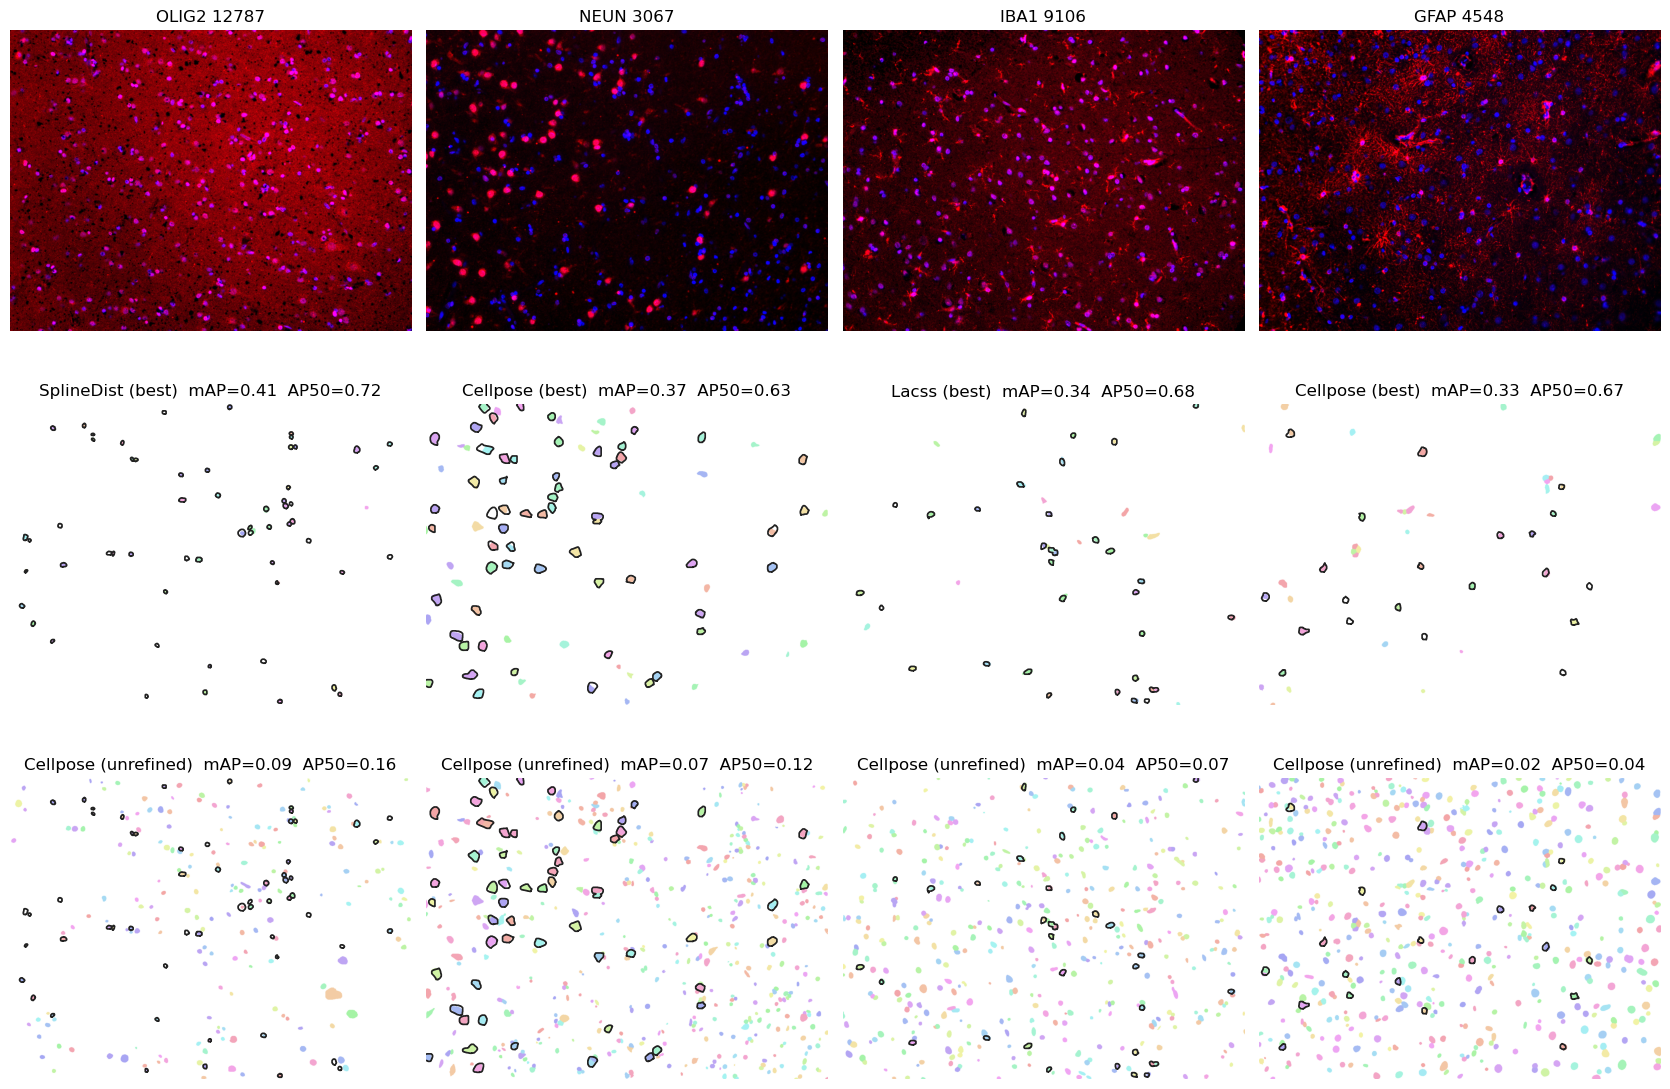

In [27]:
# All comments in ENGLISH
from pathlib import Path
import re, math, hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile as tiff
from skimage.measure import find_contours

# -------- CONFIG --------
PER_IMG = per_img_cyto
DATASET_DIR = Path("/ihome/jbwang/liy121/ifimage/00_dataset_withoutpecam")
cyto_preds = {
    "Cellpose":  Path("/ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/refilter_outputs/feat-mean_thr-otsu_area-100_gate-off"),
    "Cellpose Unrefined":  Path("/ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/cyto_prediction"),
    "StarDist":  Path("/ihome/jbwang/liy121/ifimage/02_stardist_benchmark/refilter_outputs/feat-mean_thr-otsu_area-100_gate-off"),
    "CellSAM":   Path("/ihome/jbwang/liy121/ifimage/03_cellsam_benchmark/refilter_outputs/feat-mean_thr-otsu_area-100_gate-off"),
    "MESMER":    Path("/ihome/jbwang/liy121/ifimage/04_mesmer_benchmark/refilter_outputs/feat-mean_thr-otsu_area-100_gate-off"),
    "Watershed": Path("/ihome/jbwang/liy121/ifimage/06_watershed_benchmark/refilter_outputs/feat-mean_thr-otsu_area-100_gate-off"),
    "Omnipose":  Path("/ihome/jbwang/liy121/ifimage/07_omnipose_benchmark/refilter_outputs/feat-mean_thr-otsu_area-100_gate-off"),
    "Lacss":     Path("/ihome/jbwang/liy121/ifimage/011_lacss/refilter_outputs/feat-mean_thr-otsu_area-100_gate-off"),
    "HoVerNet":  Path("/ihome/jbwang/liy121/ifimage/09_hovernet_benchmark/refilter_outputs/feat-mean_thr-otsu_area-100_gate-off"),
    "SplineDist":Path("/ihome/jbwang/liy121/ifimage/08_splinedist_benchmark/refilter_outputs/feat-mean_thr-otsu_area-100_gate-off"),
}
GROUPS = {"OLIG2": r"OLIG2", "NEUN": r"NEUN", "IBA1": r"IBA1", "GFAP": r"GFAP"}
OUT_PNG = Path("plots/best_per_celltype_report_3x4_whitebg.png")
OUT_PDF = Path("plots/best_per_celltype_report_3x4_whitebg.pdf")
BOUNDARY_W = 1.2
FILL_ALPHA = 0.92  # stronger fills on white

# -------- IO / IMAGE UTILS --------
def _load_any(p: Path) -> np.ndarray:
    return np.load(p) if p.suffix.lower()==".npy" else np.squeeze(tiff.imread(str(p)))

def _to_gray(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x)
    if x.ndim == 3:
        x = (0.2126*x[...,0] + 0.7152*x[...,1] + 0.0722*x[...,2]) if x.shape[-1] >= 3 else x.max(-1)
    elif x.ndim > 2:
        x = x.squeeze()
        if x.ndim > 2: x = x.max(0)
    return x.astype(np.float32)

def _norm01(x: np.ndarray) -> np.ndarray:
    if x.size == 0: return x.astype(np.float32)
    p1, p99 = np.percentile(x, [1, 99])
    if p99 <= p1:
        mn, mx = float(x.min()), float(x.max())
        if mx <= mn: return np.zeros_like(x, np.float32)
        p1, p99 = mn, mx
    return np.clip((x - p1) / max(p99 - p1, 1e-6), 0, 1).astype(np.float32)

def _first_match(root: Path, pats) -> Path | None:
    for pat in pats:
        hit = next(root.glob(pat), None)
        if hit is not None: return hit
    return None

def find_raw_channels(base: str):
    lead = base.split("_", 1)[0].lower()
    dapi_fp = _first_match(DATASET_DIR, [f"{base}.tif", f"{base}.tiff", f"{base}.npy",
                                         f"{base}_dapi.tif", f"{base}_dapi.tiff", f"{base}_dapi.npy"])
    marker_fp = _first_match(DATASET_DIR, [f"{base}_{lead}.tif", f"{base}_{lead}.tiff", f"{base}_{lead}.npy",
                                           f"{base}_marker.tif", f"{base}_marker.tiff", f"{base}_marker.npy"])
    d = _load_any(dapi_fp) if dapi_fp else None
    m = _load_any(marker_fp) if marker_fp else None
    return d, m

def make_composite(dapi, marker):
    # DAPI -> blue, Marker -> red
    if dapi is None and marker is None: return None
    d = _to_gray(dapi) if dapi is not None else None
    m = _to_gray(marker) if marker is not None else None
    if d is not None and m is not None:
        h, w = min(d.shape[0], m.shape[0]), min(d.shape[1], m.shape[1])
        d, m = d[:h,:w], m[:h,:w]
    base = d if d is not None else m
    H, W = base.shape
    rgb = np.zeros((H, W, 3), np.float32)
    if d is not None: rgb[...,2] = _norm01(d)  # blue
    if m is not None: rgb[...,0] = _norm01(m)  # red
    return rgb

def stack_to_label(arr):
    arr = np.asarray(arr)
    if arr.ndim == 3:
        lab = np.zeros(arr.shape[1:], np.int32); k = 0
        for i in range(arr.shape[0]):
            m = arr[i] > 0
            if m.any(): k += 1; lab[m] = k
        return lab
    return arr

def find_gt(base):
    p = DATASET_DIR / f"{base}_cellbodies.npy"
    return p if p.exists() else next(DATASET_DIR.rglob(f"{base}*cellbodies*.npy"), None)

def find_pred(base, root: Path):
    p = root / f"{base}_pred_cyto.npy"
    return p if p.exists() else next(root.rglob(f"{base}*pred*cyto*.npy"), None)

# -------- TABLE UTILS --------
def as_df(x):
    if isinstance(x, dict):
        parts = []
        for algo, df in x.items():
            if df is None or df.empty: continue
            dfx = df.copy(); dfx["algorithm"] = algo; parts.append(dfx)
        return pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()
    return x.copy()

def infer_ap_cols(df):
    ap = [c for c in df.columns if re.match(r"^AP@\d\.\d{2}$", c)]
    if not ap: raise ValueError("No AP@xx.xx columns found.")
    return sorted(ap, key=lambda c: float(c.split("@")[1]))

def per_image_scores(df: pd.DataFrame, base: str, algo: str):
    ap_cols = infer_ap_cols(df)
    sub = df[(df["base"] == base) & (df["algorithm"] == algo)]
    if sub.empty: return np.nan, np.nan
    r = sub.iloc[0]
    mAP = pd.to_numeric(r[ap_cols], errors="coerce").mean()
    ap50 = float(r.get("AP@0.50", np.nan))
    return float(mAP), ap50

# -------- LOAD & PICK BEST PER CELLTYPE --------
df = as_df(PER_IMG)
if "base" not in df.columns: raise ValueError("Missing 'base'")
if "algorithm" not in df.columns: df["algorithm"] = "model"

ap_cols = infer_ap_cols(df)
df["_score"] = pd.to_numeric(df[ap_cols].mean(axis=1), errors="coerce")
df = df.dropna(subset=["_score"])

best = []  # list of (celltype, row) where row has 'base' and 'algorithm'
for gname, pat in GROUPS.items():
    sub = df[df["base"].str.contains(pat, case=False, regex=True, na=False)]
    best.append((gname, None if sub.empty else sub.loc[sub["_score"].idxmax()]))

# -------- FIGURE 3x4 --------
cols = list(GROUPS.keys()); ncols = len(cols); nrows = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(4.2*ncols, 3.9*nrows), squeeze=False)

def draw_contours(ax, binary, color="k", lw=1.1):
    from skimage.measure import find_contours
    for cnt in find_contours(binary.astype(float), 0.5):
        ax.plot(cnt[:,1], cnt[:,0], color=color, linewidth=lw, solid_capstyle="round")

def label_viz_on_white(lab: np.ndarray, *, seed_text: str, fill_alpha: float = FILL_ALPHA) -> np.ndarray:
    H, W = lab.shape[:2]
    img = np.ones((H, W, 3), np.float32)
    ids = [i for i in np.unique(lab) if i != 0]
    if not ids: return img
    rng = np.random.default_rng(int(hashlib.sha256(seed_text.encode()).hexdigest()[:8], 16))
    hues = rng.random(len(ids)); S, V = 0.35, 0.95
    def hsv2rgb(h):
        i = int(h*6.0) % 6; f = h*6.0 - i
        p = V*(1-S); q = V*(1-S*f); t = V*(1-S*(1-f))
        return [(V,t,p),(q,V,p),(p,V,t),(p,q,V),(t,p,V),(V,p,q)][i]
    pal = np.array([hsv2rgb(h) for h in hues], np.float32)
    id2idx = {i:k for k,i in enumerate(ids)}
    for i in ids:
        m = (lab == i)
        if m.any():
            c = pal[id2idx[i]]
            img[m] = img[m]*(1-fill_alpha) + c*fill_alpha
    return img

for j, (gname, row) in enumerate(best):
    ax_raw, ax_best, ax_unref = axes[0, j], axes[1, j], axes[2, j]

    if row is None:
        for ax in (ax_raw, ax_best, ax_unref): ax.axis("off")
        ax_raw.set_title(f"{gname}: no image"); continue

    base = str(row["base"])
    algo_best = str(row.get("algorithm", "Cellpose"))
    mAP_best, ap50_best = per_image_scores(df, base, algo_best)

    # row 1: raw composite
    comp = make_composite(*find_raw_channels(base))
    if comp is None:
        ax_raw.axis("off"); ax_raw.set_title(f"{gname} | {base}\nraw missing", fontsize=9)
    else:
        ax_raw.imshow(comp); ax_raw.axis("off")
        ax_raw.set_title(base.replace("_", " ").upper(), fontsize=12)

    # load GT
    gt_path = DATASET_DIR / f"{base}_cellbodies.npy"
    if not gt_path.exists():
        gt_path = next(DATASET_DIR.rglob(f"{base}*cellbodies*.npy"), None)
    if gt_path is None or not gt_path.exists():
        for ax, tag in ((ax_best,"best"), (ax_unref,"unrefined")):
            ax.axis("off"); ax.set_title(f"{gname} | {base}\n(no GT for {tag})", fontsize=9)
        continue
    gt = stack_to_label(np.load(gt_path))

    # row 2: BEST algorithm prediction from correct folder
    root_best = cyto_preds.get(algo_best, None)
    pr_best_p = find_pred(base, root_best) if root_best is not None else None
    if pr_best_p and pr_best_p.exists():
        pr_best = stack_to_label(np.load(pr_best_p))
        # legacy: crop both to min shape
        h, w = min(gt.shape[0], pr_best.shape[0]), min(gt.shape[1], pr_best.shape[1])
        gt2, pr_best = gt[:h,:w], pr_best[:h,:w]
        ax_best.imshow(label_viz_on_white(pr_best, seed_text=f"{base}_{algo_best}"))
        draw_contours(ax_best, gt2>0, color="#222222", lw=BOUNDARY_W)
        title = f"{algo_best} (best)  "
        if not np.isnan(mAP_best):  title += f"mAP={mAP_best:.2f}  "
        if not np.isnan(ap50_best): title += f"AP50={ap50_best:.2f}"
        ax_best.set_title(title.strip(), fontsize=12)
        ax_best.axis("off")
    else:
        ax_best.axis("off"); ax_best.set_title(f"{gname} | {base}\n(no best pred found)", fontsize=9)

    # row 3: Cellpose Unrefined as common baseline
    root_unref = cyto_preds["Cellpose Unrefined"]
    pr_unref_p = find_pred(base, root_unref)
    if pr_unref_p and pr_unref_p.exists():
        pr_unref = stack_to_label(np.load(pr_unref_p))
        h, w = min(gt.shape[0], pr_unref.shape[0]), min(gt.shape[1], pr_unref.shape[1])
        gt3, pr_unref = gt[:h,:w], pr_unref[:h,:w]
        mAP_unref, ap50_unref = per_image_scores(df, base, "Cellpose Unrefined")
        ax_unref.imshow(label_viz_on_white(pr_unref, seed_text=f"{base}_CellposeUnref"))
        draw_contours(ax_unref, gt3>0, color="#222222", lw=BOUNDARY_W)
        title_unref = "Cellpose (unrefined)  "
        if not np.isnan(mAP_unref):  title_unref += f"mAP={mAP_unref:.2f}  "
        if not np.isnan(ap50_unref): title_unref += f"AP50={ap50_unref:.2f}"
        ax_unref.set_title(title_unref.strip(), fontsize=12)
        ax_unref.axis("off")
    else:
        ax_unref.axis("off"); ax_unref.set_title(f"{gname} | {base}\n(no unrefined pred)", fontsize=9)

for ax in axes.ravel():
    ax.set_xticks([]); ax.set_yticks([])

fig.tight_layout()
OUT_PNG.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(OUT_PNG, dpi=300, bbox_inches="tight")
plt.savefig(OUT_PDF, dpi=300, bbox_inches="tight")
print(f"[SAVED] {OUT_PNG}")
print(f"[SAVED] {OUT_PDF}")
plt.show()


[20/120] saved GFAP/gfap_5803.pdf + .png
[40/120] saved IBA1/iba1_7925.pdf + .png
[60/120] saved IBA1/iba1_9866.pdf + .png


KeyboardInterrupt: 

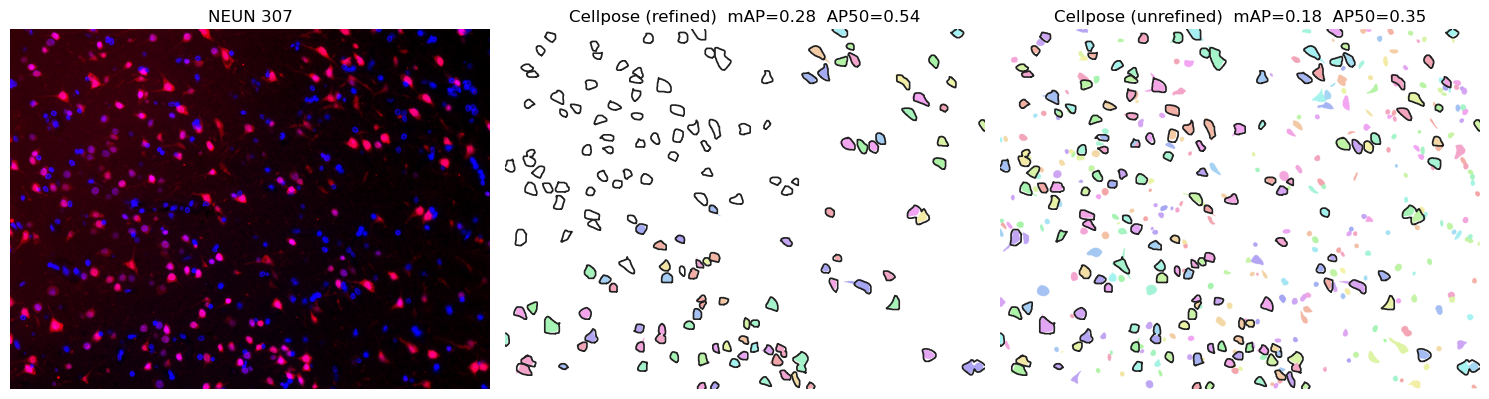

In [6]:
# ===== Compare ALL images: Cellpose vs Cellpose Unrefined =====
from matplotlib.backends.backend_pdf import PdfPages  # not used now, kept for reference
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

OUT_ROOT = Path("figs/cellpose_compare_pages")   # parent folder
OUT_ROOT.mkdir(parents=True, exist_ok=True)

# collect bases
all_bases = sorted(df["base"].dropna().astype(str).unique().tolist())

def _safe_stack_to_label(p):
    if p is None or (not p.exists()):
        return None
    arr = np.load(p)
    return stack_to_label(arr)

def _match_size(a, b):
    if a is None or b is None:
        return a, b
    h = min(a.shape[0], b.shape[0]); w = min(a.shape[1], b.shape[1])
    return a[:h, :w], b[:h, :w]

for k, base in enumerate(all_bases, 1):
    # per-image scores
    mAP_ref, ap50_ref = per_image_scores(df, base, "Cellpose")
    mAP_unr, ap50_unr = per_image_scores(df, base, "Cellpose Unrefined")

    # I/O
    comp = make_composite(*find_raw_channels(base))
    gt_path = find_gt(base)
    gt = np.load(gt_path) if (gt_path and gt_path.exists()) else None
    if gt is not None: gt = stack_to_label(gt)

    pr_ref = _safe_stack_to_label(find_pred(base, PRED_REFINED_ROOT))
    pr_unr = _safe_stack_to_label(find_pred(base, PRED_UNREFINED_ROOT))

    # align
    gt_ref = gt
    if gt is not None and pr_ref is not None:
        gt_ref, pr_ref = _match_size(gt, pr_ref)
    gt_unr = gt
    if gt is not None and pr_unr is not None:
        gt_unr, pr_unr = _match_size(gt, pr_unr)

    # figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), squeeze=False)
    ax_raw, ax_ref, ax_unr = axes[0]

    # raw
    if comp is not None:
        ax_raw.imshow(comp); ax_raw.axis("off")
        ax_raw.set_title(base.replace("_", " ").upper(), fontsize=12)
    else:
        ax_raw.axis("off"); ax_raw.set_title(f"{base}\n(raw missing)", fontsize=10)

    # refined
    if pr_ref is not None:
        ax_ref.imshow(label_viz_on_white(pr_ref, seed_text=base+"_cellpose_ref"))
        if gt_ref is not None:
            draw_contours(ax_ref, gt_ref > 0, color="#222222", lw=BOUNDARY_W)
        title = "Cellpose (refined)"
        if not np.isnan(mAP_ref):  title += f"  mAP={mAP_ref:.2f}"
        if not np.isnan(ap50_ref): title += f"  AP50={ap50_ref:.2f}"
        ax_ref.set_title(title, fontsize=12)
        ax_ref.axis("off")
    else:
        ax_ref.axis("off"); ax_ref.set_title(f"{base}\n(no refined pred)", fontsize=10)

    # unrefined
    if pr_unr is not None:
        ax_unr.imshow(label_viz_on_white(pr_unr, seed_text=base+"_cellpose_unref"))
        if gt_unr is not None:
            draw_contours(ax_unr, gt_unr > 0, color="#222222", lw=BOUNDARY_W)
        title = "Cellpose (unrefined)"
        if not np.isnan(mAP_unr):  title += f"  mAP={mAP_unr:.2f}"
        if not np.isnan(ap50_unr): title += f"  AP50={ap50_unr:.2f}"
        ax_unr.set_title(title, fontsize=12)
        ax_unr.axis("off")
    else:
        ax_unr.axis("off"); ax_unr.set_title(f"{base}\n(no unrefined pred)", fontsize=10)

    fig.tight_layout()

    # --- save per-base into a subfolder by marker prefix ---
    marker_prefix = base.split("_", 1)[0].upper()  # e.g., OLIG2/NEUN/IBA1/GFAP
    out_dir = OUT_ROOT / marker_prefix
    out_dir.mkdir(parents=True, exist_ok=True)

    fig.savefig(out_dir / f"{base}.png", dpi=250, bbox_inches="tight")
    fig.savefig(out_dir / f"{base}.pdf", dpi=250, bbox_inches="tight")
    plt.close(fig)

    if k % 20 == 0 or k == len(all_bases):
        print(f"[{k}/{len(all_bases)}] saved {marker_prefix}/{base}.pdf + .png")

print(f"[SAVED per-page PDFs/PNGs] {OUT_ROOT}  (grouped by marker)")

# Cell benchmark: AP-vs-IoU per cell-type

Saved:
  /ihome/jbwang/liy121/ifimage/plots/celltype_AP_vs_IoU_facets.pdf
  /ihome/jbwang/liy121/ifimage/plots/celltype_AP_vs_IoU_facets.png


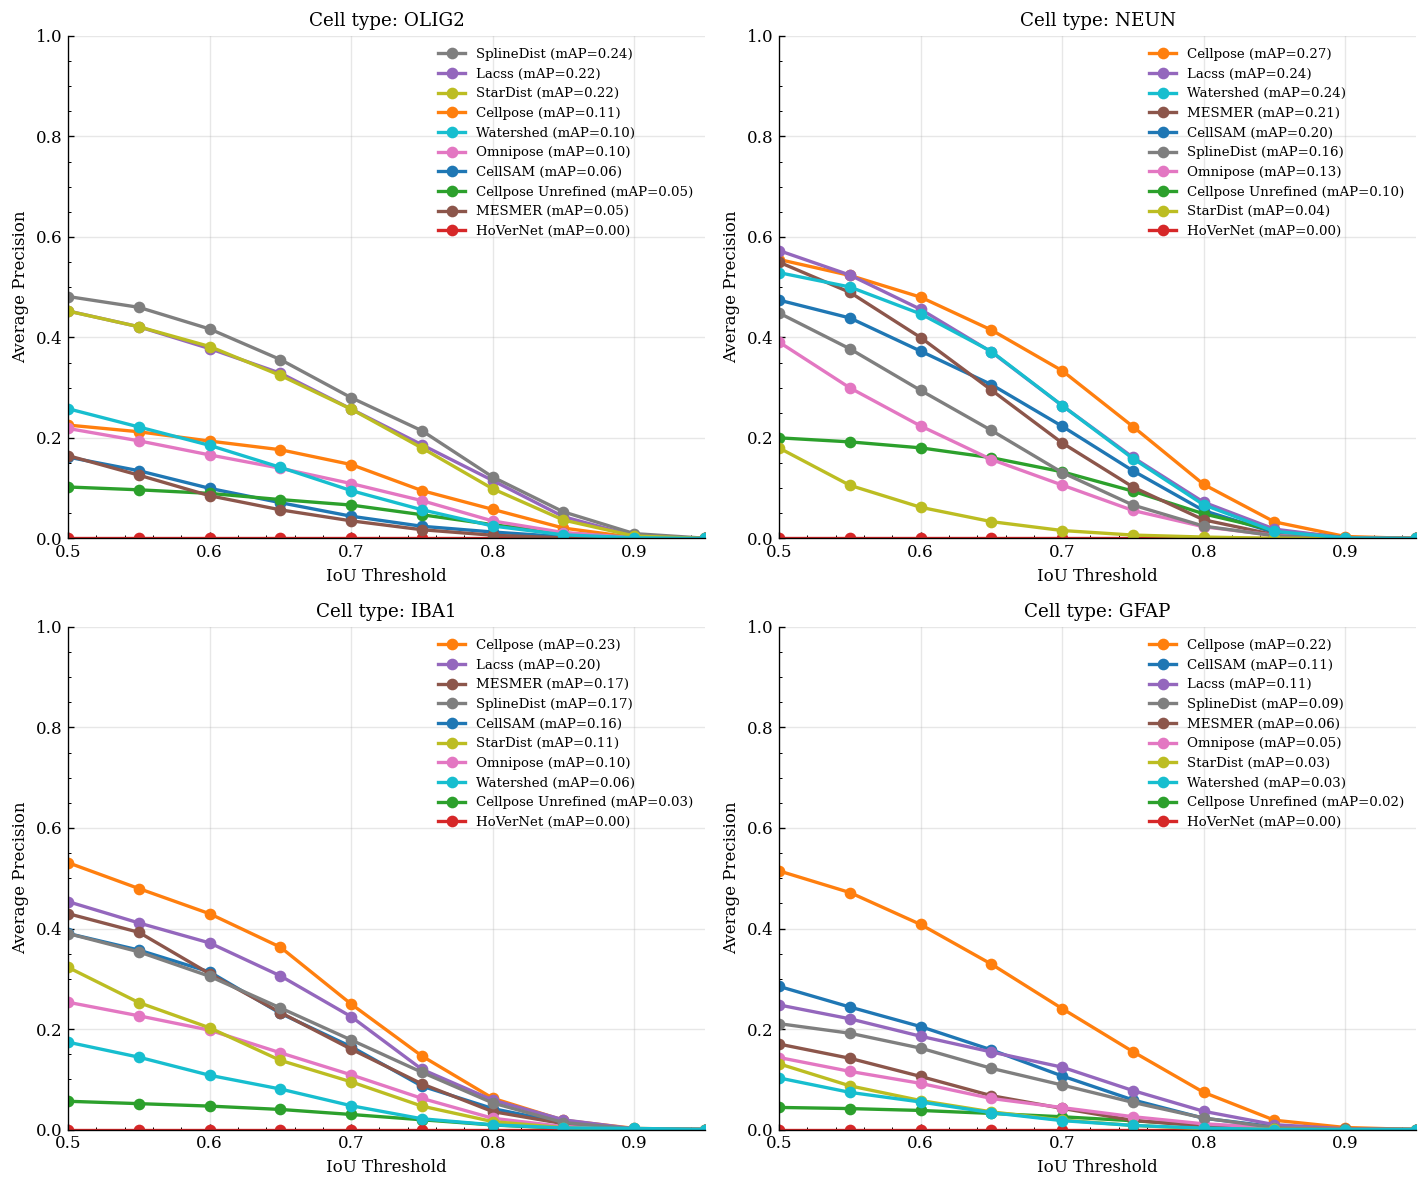

In [11]:
# —— Cell benchmark: AP-vs-IoU per cell-type (facet plot) ——
# Legend ranked high→low by mAP, "sci" style, and save to PDF/PNG.
# All comments are in ENGLISH.

import os
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- STYLE: scientific look ----------
try:
    plt.style.use(['science', 'no-latex'])  # Requires SciencePlots
except Exception:
    mpl.rcParams.update({
        "font.family": "serif",
        "font.size": 10,
        "axes.titlesize": 11,
        "axes.labelsize": 10,
        "legend.fontsize": 8,
        "xtick.direction": "in",
        "ytick.direction": "in",
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
        "grid.alpha": 0.8,
        "grid.linestyle": "-",
        "savefig.bbox": "tight",
        "figure.dpi": 120,
    })

# ---------- GROUPS ----------
groups = {
    "OLIG2": r"OLIG2",
    "NEUN":  r"NEUN",
    "IBA1":  r"IBA1",
    "GFAP":  r"GFAP",
    # "PECAM": r"PECAM",  # commented intentionally
}

ncols = 2
nrows = math.ceil(len(groups) / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 10), squeeze=False)

# ---------- PLOT ----------
for ax, (gname, pattern) in zip(axes.ravel(), groups.items()):
    sub = per_img_cyto[per_img_cyto["base"].str.contains(pattern, case=False, regex=True, na=False)]
    if sub.empty:
        ax.set_title(f"Cell type: {gname} (no images)")
        ax.axis("off")
        continue

    grp_curve = sub.groupby("algorithm")[ap_cols].mean()
    grp_mAP = grp_curve.mean(axis=1)

    line_by_algo = {}
    for algo, row in grp_curve.iterrows():
        ln, = ax.plot(thr, row.values, marker='o', linewidth=2,
                      label=f"{algo} (mAP={grp_mAP[algo]:.02f})")
        line_by_algo[algo] = ln

    # Aesthetics
    ax.set_title(f"Cell type: {gname}")
    ax.set_xlabel("IoU Threshold")
    ax.set_ylabel("Average Precision")
    ax.set_xlim(thr.min(), thr.max())
    ax.set_ylim(0, 1.0)
    ax.minorticks_on()
    ax.grid(alpha=0.3)

    # ---------- LEGEND: rank high → low by mAP ----------
    sorted_algos = sorted(grp_mAP.index, key=lambda k: grp_mAP[k], reverse=True)
    handles = [line_by_algo[a] for a in sorted_algos]
    labels  = [f"{a} (mAP={grp_mAP[a]:.02f})" for a in sorted_algos]
    ax.legend(handles, labels, fontsize=8, frameon=False)

# Hide unused axes
for j in range(len(groups), nrows * ncols):
    axes.ravel()[j].axis("off")

plt.tight_layout()

# ---------- SAVE ----------
try:
    out_dir = Path(out_dir)  # reuse from earlier if available
except NameError:
    out_dir = Path("./figs")

out_dir.mkdir(parents=True, exist_ok=True)
pdf_path = out_dir / "celltype_AP_vs_IoU_facets.pdf"
png_path = out_dir / "celltype_AP_vs_IoU_facets.png"

fig.savefig(pdf_path, format="pdf", transparent=True)
fig.savefig(png_path, format="png", dpi=300, transparent=True)

print(f"Saved:\n  {pdf_path}\n  {png_path}")

plt.show()


# Nuclei Segmentation

In [4]:
from pathlib import Path
from evaluation_core import EvalConfig, evaluate_all
import numpy as np

PRED_SUBDIR = "nuclei_prediction"

pred_dirs = {
    "CellposeSAM": Path(f"01_cellpose_benchmark/{PRED_SUBDIR}"),
    "StarDist": Path(f"02_stardist_benchmark/{PRED_SUBDIR}"),
    "CellSAM":  Path(f"03_cellsam_benchmark/{PRED_SUBDIR}"),
    "Mesmer":   Path(f"04_mesmer_benchmark/{PRED_SUBDIR}"),
    "Watershed":   Path(f"06_watershed_benchmark/{PRED_SUBDIR}"),
    "Omnipose":   Path(f"07_omnipose_benchmark/{PRED_SUBDIR}"),
    "SplineDist":   Path(f"08_splinedist_benchmark/{PRED_SUBDIR}"),
    "LACSS": Path(f"011_lacss/{PRED_SUBDIR}"),
    "Omnipose": Path(f"07_omnipose_benchmark/{PRED_SUBDIR}"),
}

# Put longer tokens before shorter ones to avoid partial stripping (e.g., "_pred_nuclei" before "_nuc").
pred_strip = {
    "CellposeSAM": [
        "_cp_masks", "_cp_mask",
        "_labels", "_label",
        "_masks", "_mask",
        "_pred_nuclei", "_pred_nuc",
        "_prediction", "_refined", "_filtered", "_filter",
        "_nuclei", "_nuc",
    ],
    "StarDist": [
        "_stardist_nuclei", "_stardist_nuc", "_stardist",
        "_pred_nuclei", "_pred_nuc",
        "_prediction", "_refined", "_filtered", "_filter",
        "_nuclei", "_nuc",
    ],
    "CellSAM": [
        "_cellsam", "_sam",
        "_masks", "_mask", "_labels", "_label",
        "_pred_nuclei", "_pred_nuc",
        "_prediction", "_refined", "_filtered", "_filter",
        "_nuclei", "_nuc",
    ],
    "Mesmer": [
        "_pred_nuclei", "_pred_nuc",
        "_prediction", "_refined", "_filtered", "_filter",
        "_nuclei", "_nuc",
        "_mesmer",
    ],
    "Watershed": [
        "_pred_nuclei", "_pred_nuc",
        "_prediction", "_refined", "_filtered", "_filter",
        "_nuclei", "_nuc",
        "_mesmer",
    ],
    "Omnipose": [
        "_pred_nuclei", "_pred_nuc",
        "_prediction", "_refined", "_filtered", "_filter",
        "_nuclei", "_nuc",
        "_mesmer",
    ],
    "SplineDist": [
        "_pred_nuclei", "_pred_nuc",
        "_prediction", "_refined", "_filtered", "_filter",
        "_nuclei", "_nuc",
        "_mesmer",
    ],
    "LACSS": [
        "_pred_nuclei", "_pred_nuc",
        "_prediction", "_refined", "_filtered", "_filter",
        "_nuclei", "_nuc",
        "_mesmer",
    ],
    "Omnipose": [
        "_pred_nuclei", "_pred_nuc",
        "_prediction", "_refined", "_filtered", "_filter",
        "_nuclei", "_nuc",
        "_mesmer",
    ],
}

cfg = EvalConfig(
    gt_dir=Path("00_dataset"),
    pred_dirs=pred_dirs,
    gt_glob="*_dapimultimask.npy",
    pred_glob="*.npy",
    gt_strip=["_dapimultimask"],
    pred_strip=pred_strip,
    ap_thresholds=tuple(np.round(np.arange(0.50, 0.96, 0.05), 2)),
    boundary_scales=(1.0, 2.0),
)

per_img_nuc, sum_nuc = evaluate_all(cfg)

[eval] starting ALL: 8 algorithms
Now Evaluating 01_cellpose_benchmark/nuclei_prediction
[eval] CellposeSAM: 33 image pairs | workers=48


evaluation_core.py (113): nuclei_prediction: 94 predictions had no GT (e.g., ['gfap_3527', 'gfap_3532', 'gfap_3569']).
CellposeSAM: 100%|██████████| 33/33 [00:30<00:00,  1.10img/s]


[eval] CellposeSAM: finished in 30.38s
Now Evaluating 02_stardist_benchmark/nuclei_prediction
[eval] StarDist: 33 image pairs | workers=48


evaluation_core.py (113): nuclei_prediction: 94 predictions had no GT (e.g., ['gfap_3527', 'gfap_3532', 'gfap_3569']).
StarDist: 100%|██████████| 33/33 [00:29<00:00,  1.10img/s]

[eval] StarDist: finished in 30.27s
Now Evaluating 03_cellsam_benchmark/nuclei_prediction
[eval] CellSAM: 3 image pairs | workers=48



evaluation_core.py (111): nuclei_prediction: 30 GT files had no prediction (e.g., ['gfap_6390', 'iba1_8405', 'iba1_8406']).
evaluation_core.py (113): nuclei_prediction: 17 predictions had no GT (e.g., ['gfap_3527', 'gfap_3532', 'gfap_3569']).
CellSAM: 100%|██████████| 3/3 [00:03<00:00,  1.18s/img]

[eval] CellSAM: finished in 3.82s
Now Evaluating 04_mesmer_benchmark/nuclei_prediction
[eval] Mesmer: 33 image pairs | workers=48



evaluation_core.py (113): nuclei_prediction: 94 predictions had no GT (e.g., ['gfap_3527', 'gfap_3532', 'gfap_3569']).
Mesmer: 100%|██████████| 33/33 [00:29<00:00,  1.11img/s]

[eval] Mesmer: finished in 30.14s
Now Evaluating 06_watershed_benchmark/nuclei_prediction
[eval] Watershed: 33 image pairs | workers=48



evaluation_core.py (113): nuclei_prediction: 94 predictions had no GT (e.g., ['gfap_3527', 'gfap_3532', 'gfap_3569']).
Watershed: 100%|██████████| 33/33 [00:30<00:00,  1.09img/s]

[eval] Watershed: finished in 30.58s
Now Evaluating 07_omnipose_benchmark/nuclei_prediction
[eval] Omnipose: 33 image pairs | workers=48



evaluation_core.py (113): nuclei_prediction: 94 predictions had no GT (e.g., ['gfap_3527', 'gfap_3532', 'gfap_3569']).
Omnipose: 100%|██████████| 33/33 [00:30<00:00,  1.10img/s]

[eval] Omnipose: finished in 30.37s
Now Evaluating 08_splinedist_benchmark/nuclei_prediction
[eval] SplineDist: 33 image pairs | workers=48



evaluation_core.py (113): nuclei_prediction: 94 predictions had no GT (e.g., ['gfap_3527', 'gfap_3532', 'gfap_3569']).
SplineDist: 100%|██████████| 33/33 [00:29<00:00,  1.11img/s]


[eval] SplineDist: finished in 30.01s
Now Evaluating 011_lacss/nuclei_prediction
[eval] LACSS: 33 image pairs | workers=48


evaluation_core.py (113): nuclei_prediction: 94 predictions had no GT (e.g., ['gfap_3527', 'gfap_3532', 'gfap_3569']).
LACSS: 100%|██████████| 33/33 [00:29<00:00,  1.12img/s]


[eval] LACSS: finished in 29.84s
[eval] ALL done


In [5]:
# All comments in ENGLISH
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# ---------- STYLE HELPERS ----------
def _apply_science_style():
    """
    Apply a scientific figure style:
      - Prefer 'science' (SciencePlots) if installed, with 'no-latex'
      - Otherwise, use a clean Matplotlib fallback suitable for publications.
    """
    try:
        plt.style.use(['science', 'no-latex'])  # requires the 'SciencePlots' package
    except Exception:
        mpl.rcParams.update({
            "font.family": "serif",
            "font.size": 10,
            "axes.titlesize": 11,
            "axes.labelsize": 10,
            "legend.fontsize": 9,
            "xtick.direction": "in",
            "ytick.direction": "in",
            "axes.spines.top": False,
            "axes.spines.right": False,
            "axes.grid": True,
            "grid.alpha": 0.3,
            "grid.linestyle": "-",
            "savefig.bbox": "tight",
            "figure.dpi": 120,
        })

def _save_both(fig: plt.Figure, base: Path, dpi: int = 300, transparent: bool = True):
    """
    Save figure as both PDF (vector) and PNG (raster).
    `base` can be a full filename (with or without extension) or a basename.
    """
    base = Path(base)
    if base.suffix:  # if user passed something like "plot.png", strip suffix for twin saves
        base = base.with_suffix("")
    base.parent.mkdir(parents=True, exist_ok=True)
    pdf_path = base.with_suffix(".pdf")
    png_path = base.with_suffix(".png")
    fig.savefig(pdf_path, format="pdf", transparent=transparent)
    fig.savefig(png_path, format="png", dpi=dpi, transparent=transparent)
    print(f"Saved:\n  {pdf_path}\n  {png_path}")


# ---------- YOUR HELPERS (tweaked only minimally) ----------
def _as_perimg_df(per_img):
    """
    Accept either:
      - dict: {algo_name: per-image DataFrame}, OR
      - DataFrame: with or without 'algorithm' column.
    Return a single DataFrame with an 'algorithm' column.
    """
    if isinstance(per_img, dict):
        parts = []
        for algo, df in per_img.items():
            if df is None or len(df) == 0:
                continue
            df = df.copy()
            if "algorithm" not in df.columns:
                df["algorithm"] = algo
            else:
                # ensure the algorithm column actually says the dict key
                df["algorithm"] = algo
            parts.append(df)
        return pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()
    elif isinstance(per_img, pd.DataFrame):
        df = per_img.copy()
        if "algorithm" not in df.columns:
            df["algorithm"] = "model"
        return df
    else:
        raise TypeError("per_img must be a dict[str, DataFrame] or a DataFrame.")

def _infer_ap_cols(df):
    """
    Find AP columns named like 'AP@0.50', 'AP@0.55', ...
    Return (thr_array, ordered_ap_cols).
    """
    ap_cols = [c for c in df.columns if re.match(r"^AP@\d\.\d{2}$", c)]
    if not ap_cols:
        raise ValueError("No AP@xx.xx columns found in per-image table.")
    thr = np.array([float(c.split("@")[1]) for c in ap_cols], dtype=float)
    order = np.argsort(thr)
    thr = thr[order]
    ap_cols = [ap_cols[i] for i in order]
    return thr, ap_cols


# ---------- PLOTS ----------
def plot_ap_curves_multi(
    per_img,
    out_png: Path = None,  # kept for backward-compat
    title: str = "Nuclei benchmark — overall",
    dpi: int = 300,
    out_base: Path | None = None,  # NEW: if provided, saves both PDF + PNG with this base
):
    """
    Build AP curves per algorithm and plot multiple lines.
    Also compute mAP (mean over thresholds) per algorithm.
    Returns (curve_df, mAP_series).
    """
    _apply_science_style()

    df = _as_perimg_df(per_img)
    if df.empty:
        print("No matched GT/prediction pairs. Check filename pairing (gt_strip/pred_strip).")
        return None, None

    thr, ap_cols = _infer_ap_cols(df)

    # Safety check: ensure all AP columns exist
    missing = [c for c in ap_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing AP columns: {missing}")

    # Mean across images per algorithm -> AP curve matrix
    curve = df.groupby("algorithm", sort=True)[ap_cols].mean()
    mAP = curve.mean(axis=1)

    # Sort algorithms by descending mAP (legend will follow plotting order)
    sorted_mAP = mAP.sort_values(ascending=False)
    sorted_curve = curve.loc[sorted_mAP.index]

    # Plot curves
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot(111)

    # Draw in sorted order so legend is ranked high → low by mAP
    for algo, row in sorted_curve.iterrows():
        ax.plot(
            thr, row.values,
            marker="o", linewidth=2,
            label=f"{algo} (mAP={mAP[algo]:.2f})"
        )

    ax.set_title(title)
    ax.set_xlabel("IoU Threshold")
    ax.set_ylabel("Average Precision(AP)")
    ax.set_xlim(thr[0], thr[-1])
    ax.set_ylim(0.0, 1.0)
    ax.minorticks_on()
    ax.grid(alpha=0.3)
    ax.legend(frameon=False)
    fig.tight_layout()

    # Saving logic:
    if out_base is not None:
        _save_both(fig, Path(out_base), dpi=dpi, transparent=True)
    elif out_png is not None:
        # Back-compat: if only PNG path was given, save PNG AND a twin PDF
        base = Path(out_png).with_suffix("")  # remove .png if present
        _save_both(fig, base, dpi=dpi, transparent=True)

    plt.show()
    return curve, mAP


def plot_map_bars(
    mAP,
    out_png: Path = None,  # kept for backward-compat
    dpi: int = 300,
    title: str = "mAP (mean over IoU thresholds)",
    out_base: Path | None = None,  # NEW: if provided, saves both PDF + PNG with this base
):
    """
    Plot a simple bar chart for per-algorithm mAP.
    Legend not needed; bars are labeled by algo on x-axis.
    """
    _apply_science_style()

    if mAP is None or len(mAP) == 0:
        print("Empty mAP; nothing to plot.")
        return

    mAP = mAP.sort_values(ascending=False)

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    mAP.plot(kind="bar", ax=ax)
    ax.set_ylabel("mAP")
    ax.set_ylim(0.0, 1.0)
    ax.set_title(title)
    ax.grid(axis="y", alpha=0.3)
    fig.tight_layout()

    # Saving logic:
    if out_base is not None:
        _save_both(fig, Path(out_base), dpi=dpi, transparent=True)
    elif out_png is not None:
        base = Path(out_png).with_suffix("")
        _save_both(fig, base, dpi=dpi, transparent=True)

    plt.show()

Saved:
  figs/nuclei_overall_ap.pdf
  figs/nuclei_overall_ap.png


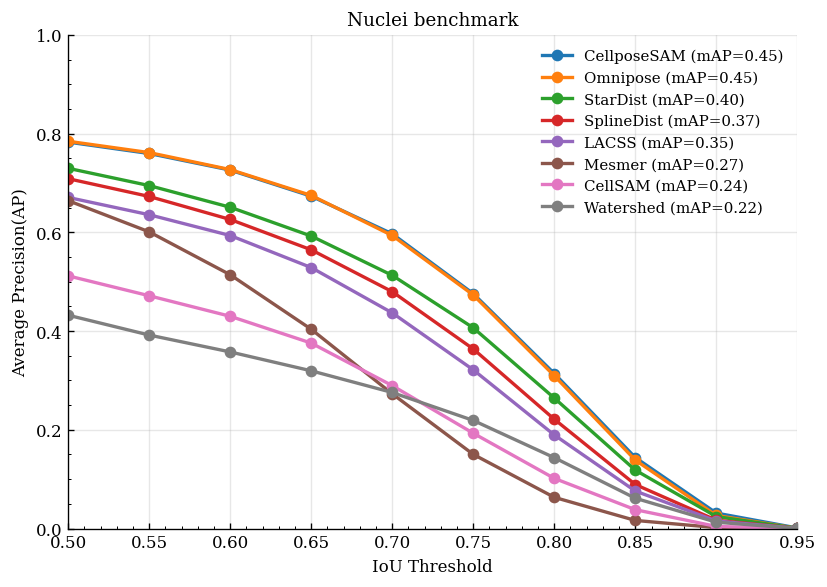

In [6]:
import re
# per_img_nuc can be a dict of DataFrames OR a single DataFrame.
curve, mAP = plot_ap_curves_multi(
    per_img=per_img_nuc,
    out_png=Path("figs/nuclei_overall_ap.png"),
    title="Nuclei benchmark",
    dpi=400,
)

[font] Using: Liberation Sans
Saved:
  figs/ap_cell_vs_nuclei_side_by_side.pdf
  figs/ap_cell_vs_nuclei_side_by_side.png


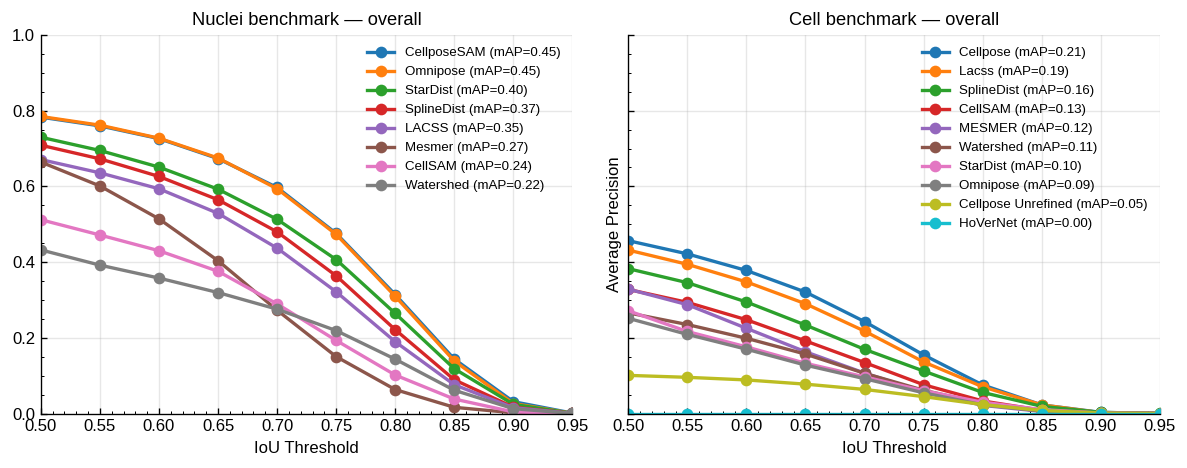

In [15]:
# -*- coding: utf-8 -*-
# Full script: same-height side-by-side AP curves (Cell vs. Nuclei) with Arial (or fallbacks)
from pathlib import Path
import io
import os
import re
import sys
import urllib.request
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# =========================
# ===== FONT HANDLING =====
# =========================
# Where to store downloaded fonts (if needed)
FONT_DIR = Path("/ihome/jbwang/liy121/fonts")          # 你要“直接下载到路径”的目录，可改成绝对路径
AUTO_DOWNLOAD_ARIMO = True          # 若无 Arial，自动下载 Arimo（Arial 兼容）到 FONT_DIR
ARIMO_TTFS = {
    "Arimo-Regular.ttf": "https://github.com/googlefonts/Arimo/raw/main/fonts/ttf/Arimo-Regular.ttf",
    "Arimo-Bold.ttf": "https://github.com/googlefonts/Arimo/raw/main/fonts/ttf/Arimo-Bold.ttf",
    "Arimo-Italic.ttf": "https://github.com/googlefonts/Arimo/raw/main/fonts/ttf/Arimo-Italic.ttf",
    "Arimo-BoldItalic.ttf": "https://github.com/googlefonts/Arimo/raw/main/fonts/ttf/Arimo-BoldItalic.ttf",
}

def _font_installed(face_name: str) -> bool:
    try:
        return any(f.name == face_name for f in fm.fontManager.ttflist)
    except Exception:
        return False

def _download_arimo(dst_dir: Path) -> bool:
    """Download Arimo TTFs to dst_dir; return True if at least one file saved."""
    dst_dir.mkdir(parents=True, exist_ok=True)
    ok = False
    for fname, url in ARIMO_TTFS.items():
        out = dst_dir / fname
        if out.exists() and out.stat().st_size > 0:
            ok = True
            continue
        try:
            with urllib.request.urlopen(url, timeout=30) as r:
                data = r.read()
            out.write_bytes(data)
            ok = True
        except Exception as e:
            # 不中断，尽力而为
            print(f"[font] Failed to fetch {fname}: {e}", file=sys.stderr)
    return ok

def _register_dir_fonts(dir_path: Path):
    """Register all .ttf/.otf in dir_path with Matplotlib."""
    if not dir_path.exists():
        return
    for p in dir_path.glob("*.ttf"):
        try:
            fm.fontManager.addfont(str(p))
        except Exception:
            pass
    for p in dir_path.glob("*.otf"):
        try:
            fm.fontManager.addfont(str(p))
        except Exception:
            pass
    try:
        fm._rebuild()
    except Exception:
        pass

def ensure_arial_or_fallback():
    """
    Priority:
      1) Arial (if installed)
      2) Liberation Sans (你机器已有)
      3) Arimo (若允许则自动下载注册到 ./fonts)
      4) DejaVu Sans / Nimbus Sans / Droid Sans
    Returns: the first available name actually used.
    """
    # 尝试先注册 FONT_DIR 中可能已有的字体
    _register_dir_fonts(FONT_DIR)

    if _font_installed("Arial"):
        return "Arial"

    if _font_installed("Liberation Sans"):
        return "Liberation Sans"

    # 尝试 Arimo：若未安装且允许下载，则下载并注册
    if not _font_installed("Arimo") and AUTO_DOWNLOAD_ARIMO:
        print(f"[font] Arial not found. Downloading Arimo to {FONT_DIR.resolve()} ...")
        if _download_arimo(FONT_DIR):
            _register_dir_fonts(FONT_DIR)

    if _font_installed("Arimo"):
        return "Arimo"

    # 兜底：这些一般随系统/Matplotlib 附带
    for name in ["DejaVu Sans", "Nimbus Sans", "Droid Sans", "Liberation Sans Narrow"]:
        if _font_installed(name):
            return name

    # 最后兜底：使用 Matplotlib 默认
    return "sans-serif"

def apply_pub_style():
    """Apply publication-like style and set font family order with Arial-first semantics."""
    # Optional SciencePlots
    try:
        plt.style.use(['science', 'no-latex'])
    except Exception:
        pass

    chosen = ensure_arial_or_fallback()

    # 构建 font.sans-serif 优先级列表（将 chosen 放在最前）
    preferred = [chosen, "Arial", "Liberation Sans", "Arimo", "DejaVu Sans", "Nimbus Sans", "Droid Sans"]
    existing = list(mpl.rcParams.get("font.sans-serif", []))
    ordered = []
    for f in preferred + existing:
        if f not in ordered:
            ordered.append(f)

    mpl.rcParams.update({
        "font.family": "sans-serif",
        "font.sans-serif": ordered,
        "font.size": 10,
        "axes.titlesize": 11,
        "axes.labelsize": 10,
        "legend.fontsize": 9,
        "xtick.direction": "in",
        "ytick.direction": "in",
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
        "grid.alpha": 0.3,
        "grid.linestyle": "-",
        "savefig.bbox": "tight",
        "figure.dpi": 120,
        "mathtext.fontset": "dejavusans",
    })

    print(f"[font] Using: {chosen}")

# =========================
# ====== PLOT HELPERS =====
# =========================
def as_perimg_df(per_img):
    """
    per_img 可为:
      - dict: {algo_name: per-image DataFrame}
      - DataFrame: 含或不含 'algorithm' 列
    返回合并后的 DataFrame，保证含 'algorithm' 列。
    """
    if isinstance(per_img, dict):
        parts = []
        for algo, df in per_img.items():
            if df is None or len(df) == 0:
                continue
            df = df.copy()
            df["algorithm"] = algo
            parts.append(df)
        return pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()
    elif isinstance(per_img, pd.DataFrame):
        df = per_img.copy()
        if "algorithm" not in df.columns:
            df["algorithm"] = "model"
        return df
    else:
        raise TypeError("per_img must be dict[str, DataFrame] or DataFrame.")

def infer_ap_cols(df: pd.DataFrame):
    """检测 'AP@0.50' 这类列；返回 (thr_array, ordered_cols)。"""
    ap_cols = [c for c in df.columns if re.match(r"^AP@\d\.\d{2}$", c)]
    if not ap_cols:
        raise ValueError("No AP@xx.xx columns found.")
    thr = np.array([float(c.split("@")[1]) for c in ap_cols], dtype=float)
    order = np.argsort(thr)
    thr = thr[order]
    ap_cols = [ap_cols[i] for i in order]
    return thr, ap_cols

def ap_curve_and_map(per_img):
    """
    计算：
      - curve: 每算法每 IoU 的 AP 均值（DataFrame: algo x thresholds）
      - mAP:   每算法在阈值上的平均（Series）
      - thr:   IoU 阈值数组
    """
    df = as_perimg_df(per_img)
    if df.empty:
        return pd.DataFrame(), pd.Series(dtype=float), np.array([])
    thr, ap_cols = infer_ap_cols(df)
    curve = df.groupby("algorithm", sort=True)[ap_cols].mean()
    mAP = curve.mean(axis=1)
    return curve, mAP, thr

def save_both(fig: plt.Figure, base: Path, dpi: int = 400, transparent: bool = True):
    base = Path(base)
    if base.suffix:
        base = base.with_suffix("")
    base.parent.mkdir(parents=True, exist_ok=True)
    pdf = base.with_suffix(".pdf")
    png = base.with_suffix(".png")
    fig.savefig(pdf, format="pdf", transparent=transparent)
    fig.savefig(png, format="png", dpi=dpi, transparent=transparent)
    print(f"Saved:\n  {pdf}\n  {png}")

def plot_two_panels_same_axes(
    per_img_cell,
    per_img_nuc,
    title_left="Cell benchmark — overall",
    title_right="Nuclei benchmark — overall",
    out_base="figs/ap_cell_vs_nuclei_side_by_side",
    figsize=(10, 4.0),
    dpi=400,
):
    """并排、同坐标范围 AP 曲线，保存 PDF+PNG。"""
    apply_pub_style()

    curve_c, mAP_c, thr_c = ap_curve_and_map(per_img_cell)
    curve_n, mAP_n, thr_n = ap_curve_and_map(per_img_nuc)

    if curve_c.empty and curve_n.empty:
        raise ValueError("Both cell and nuclei inputs are empty.")
    if curve_c.empty:
        print("Warning: cell data empty — plotting nuclei only.")
    if curve_n.empty:
        print("Warning: nuclei data empty — plotting cell only.")

    # 统一坐标轴范围/刻度
    shared_thr = np.round(np.arange(0.50, 0.96, 0.05), 2)  # 0.50–0.95 step 0.05
    x_min, x_max = shared_thr[0], shared_thr[-1]
    y_min, y_max = 0.0, 1.0

    def reindex_curve(curve):
        if curve.empty:
            return curve
        target = [f"AP@{t:.2f}" for t in shared_thr]
        for col in target:
            if col not in curve.columns:
                curve[col] = np.nan
        return curve[target]

    curve_c = reindex_curve(curve_c)
    curve_n = reindex_curve(curve_n)

    if not curve_c.empty:
        mAP_c = curve_c.mean(axis=1)
        curve_c = curve_c.loc[mAP_c.sort_values(ascending=False).index]
    if not curve_n.empty:
        mAP_n = curve_n.mean(axis=1)
        curve_n = curve_n.loc[mAP_n.sort_values(ascending=False).index]

    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
    axR, axL = axes

    # 左图：Cell
    if not curve_c.empty:
        for algo, row in curve_c.iterrows():
            axL.plot(shared_thr, row.values, marker="o", linewidth=2,
                     label=f"{algo} (mAP={mAP_c[algo]:.2f})")
    axL.set_title(title_left)
    axL.set_xlabel("IoU Threshold")
    axL.set_ylabel("Average Precision")
    axL.set_xlim(x_min, x_max)
    axL.set_ylim(y_min, y_max)
    axL.minorticks_on()
    axL.grid(alpha=0.3)
    if not curve_c.empty:
        axL.legend(frameon=False, fontsize=8)

    # 右图：Nuclei
    if not curve_n.empty:
        for algo, row in curve_n.iterrows():
            axR.plot(shared_thr, row.values, marker="o", linewidth=2,
                     label=f"{algo} (mAP={mAP_n[algo]:.2f})")
    axR.set_title(title_right)
    axR.set_xlabel("IoU Threshold")
    axR.set_xlim(x_min, x_max)
    axR.set_ylim(y_min, y_max)
    axR.minorticks_on()
    axR.grid(alpha=0.3)
    if not curve_n.empty:
        axR.legend(frameon=False, fontsize=8)

    # 统一 x 刻度与标签
    axL.set_xticks(shared_thr); axR.set_xticks(shared_thr)
    xtlabs = [f"{t:.2f}" for t in shared_thr]
    axL.set_xticklabels(xtlabs); axR.set_xticklabels(xtlabs)

    fig.tight_layout()
    save_both(fig, Path(out_base), dpi=dpi, transparent=True)
    plt.show()
    return fig

# =========================
# ========= RUN ===========
# 需要你环境里已有变量：per_img_cyto（细胞），per_img_nuc（核）
# 直接运行下行调用（可按需改保存路径和标题）：
fig = plot_two_panels_same_axes(
    per_img_cell=per_img_cyto,
    per_img_nuc=per_img_nuc,
    title_left="Cell benchmark",
    title_right="Nuclei benchmark",
    out_base="figs/ap_cell_vs_nuclei_side_by_side",
    figsize=(10, 4.0),
    dpi=400,
)


Saved:
  ./figs/nuclei_AP_vs_IoU_by_group.pdf
  ./figs/nuclei_AP_vs_IoU_by_group.png


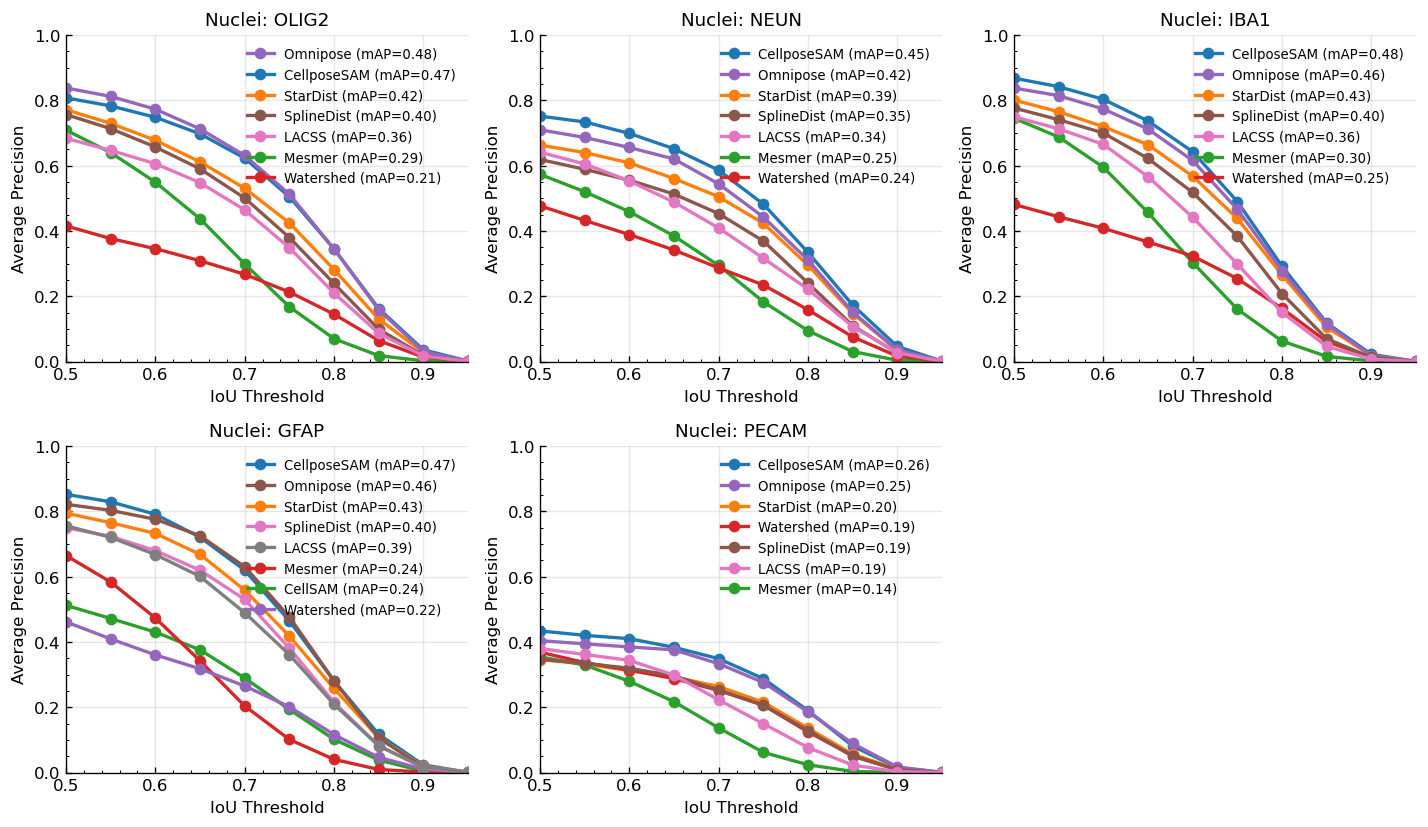

In [9]:
# ——— Nuclei benchmark: AP-vs-IoU curves per group (facet plot) ———
# Legend ranked high→low by mAP, "sci" style, and save to PDF/PNG.
# All comments are in ENGLISH.

import os
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# ---------- STYLE: prefer SciencePlots if available ----------
# Try to use the 'science' style (from SciencePlots). If not installed, fall back
# to a clean Matplotlib configuration that looks "scientific".
try:
    plt.style.use(['science', 'no-latex'])  # requires 'SciencePlots' pip package
except Exception:
    # Fallback: serif font, tighter layout, inward ticks, minor ticks, thinner spines.
    mpl.rcParams.update({
        "font.family": "sans-serif",
        "font.size": 10,
        "axes.titlesize": 11,
        "axes.labelsize": 10,
        "legend.fontsize": 8,
        "xtick.direction": "in",
        "ytick.direction": "in",
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
        "grid.alpha": 0.3,
        "grid.linestyle": "-",
        "savefig.bbox": "tight",
        "figure.dpi": 120,
    })

# ---------- INPUTS / SANITY CHECKS ----------
if 'thr' not in globals():
    thr = np.arange(0.50, 0.96, 0.05)
if 'ap_cols' not in globals():
    ap_cols = [f"AP@{t:.2f}" for t in thr]

groups = {
    "OLIG2": r"OLIG2",
    "NEUN":  r"NEUN",
    "IBA1":  r"IBA1",
    "GFAP":  r"GFAP",
    "PECAM": r"PECAM",
}

# Require a DataFrame named `per_img_nuc` with columns:
# ['base', 'algorithm', ... AP@0.50 ... AP@0.95 ...]
if per_img_nuc.empty:
    raise ValueError("per_img_nuc is empty (no matched GT/pred pairs). Check pairing rules.")

missing_cols = [c for c in ap_cols if c not in per_img_nuc.columns]
if missing_cols:
    raise ValueError(f"Missing AP columns: {missing_cols}. "
                     f"Ensure ap_thresholds={tuple(np.round(thr, 2))}.")

if "algorithm" not in per_img_nuc.columns:
    raise ValueError("Missing required column: 'algorithm'.")

if "base" not in per_img_nuc.columns:
    raise ValueError("Missing required column: 'base' used for grouping by panel names.")

# ---------- LAYOUT ----------
ncols = 3
nrows = math.ceil(len(groups) / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 7), squeeze=False)

# ---------- PLOTTING ----------
for ax, (gname, pattern) in zip(axes.ravel(), groups.items()):
    # Subset images belonging to this panel/group
    sub = per_img_nuc[per_img_nuc["base"].str.contains(pattern, case=False, regex=True, na=False)]

    if sub.empty:
        ax.set_title(f"Nuclei: {gname} (no images)")
        ax.axis("off")
        continue

    # Mean AP curve across images for each algorithm
    grp_curve = sub.groupby("algorithm", sort=False)[ap_cols].mean()

    # mAP = mean across IoU thresholds
    grp_mAP = grp_curve.mean(axis=1)

    # Keep line handles by algorithm so we can sort legend independently of plot order
    line_by_algo = {}

    # Plot each algorithm's AP-vs-IoU curve
    for algo, row in grp_curve.iterrows():
        ln, = ax.plot(
            thr, row.values,
            marker='o', linewidth=2,
            label=f"{algo} (mAP={grp_mAP[algo]:.02f})"
        )
        line_by_algo[algo] = ln

    # Axes cosmetics
    ax.set_title(f"Nuclei: {gname}")
    ax.set_xlabel("IoU Threshold")
    ax.set_ylabel("Average Precision")
    ax.set_xlim(thr.min(), thr.max())
    ax.set_ylim(0, 1.0)
    ax.minorticks_on()
    ax.grid(alpha=0.3)

    # ---------- LEGEND ranked high→low by mAP ----------
    # Sort algorithms by descending mAP and build legend in that order.
    sorted_algos = sorted(grp_mAP.index, key=lambda k: grp_mAP[k], reverse=True)
    handles = [line_by_algo[a] for a in sorted_algos]
    labels  = [f"{a} (mAP={grp_mAP[a]:.02f})" for a in sorted_algos]
    ax.legend(handles, labels, fontsize=8, frameon=False)

# Hide any unused axes (if groups < nrows*ncols)
for ax in axes.ravel()[len(groups):]:
    ax.axis("off")

plt.tight_layout()

# ---------- SAVE FIGURES ----------
# Pay attention to the file path: set your desired output directory here.
out_dir = "./figs"  # change if you want a different path
os.makedirs(out_dir, exist_ok=True)

pdf_path = os.path.join(out_dir, "nuclei_AP_vs_IoU_by_group.pdf")
png_path = os.path.join(out_dir, "nuclei_AP_vs_IoU_by_group.png")

# Save high-quality vector PDF and a high-DPI PNG
fig.savefig(pdf_path, format="pdf", transparent=True)
fig.savefig(png_path, format="png", dpi=300, transparent=True)

print(f"Saved:\n  {pdf_path}\n  {png_path}")

plt.show()


# Oval shape Problem

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
from pathlib import Path

# ---------------- CONFIG ----------------
DATASET_DIR = Path("00_dataset")
OUT_DIR = Path("overlay_outputs")
OUT_DIR.mkdir(exist_ok=True, parents=True)

NUC_GT_SUFFIX = "_ovaldapimultimask.npy"
DAPI_SUFFIXES = (".tiff", ".tif")


def stack_to_label(mask_stack: np.ndarray) -> np.ndarray:
    """
    Convert a binary mask stack (N, H, W) into a single labeled mask (H, W).
    Each nucleus gets a unique integer ID.
    """
    if mask_stack.ndim == 3:
        label_img = np.zeros(mask_stack.shape[1:], dtype=np.int32)
        for i, mask in enumerate(mask_stack, 1):
            label_img[mask > 0] = i
        return label_img
    return mask_stack  # already label map


def save_overlay(dapi_path: Path, mask_path: Path, out_dir: Path, alpha=0.4):
    dapi_img = tiff.imread(dapi_path)
    mask_data = np.load(mask_path)

    # convert if it's a stack
    masks = stack_to_label(mask_data)

    plt.figure(figsize=(8, 8))
    plt.imshow(dapi_img, cmap="gray")
    plt.imshow(masks, cmap="nipy_spectral", alpha=alpha)
    plt.axis("off")
    plt.title(f"{dapi_path.stem}")

    # save to OUT_DIR
    out_path = out_dir / f"{dapi_path.stem}_overlay.png"
    plt.savefig(out_path, bbox_inches="tight", dpi=200)
    plt.close()
    print(f"[SAVED] {out_path}")


def find_and_save_all(dataset_dir: Path, out_dir: Path):
    for mask_path in dataset_dir.rglob(f"*{NUC_GT_SUFFIX}"):
        base = mask_path.name.replace(NUC_GT_SUFFIX, "")
        dapi_path = None
        for suf in DAPI_SUFFIXES:
            candidate = mask_path.parent / f"{base}{suf}"
            if candidate.exists():
                dapi_path = candidate
                break

        if dapi_path is None:
            print(f"[WARN] No DAPI found for {mask_path.name}")
            continue

        save_overlay(dapi_path, mask_path, out_dir)


# ---------------- RUN ----------------
find_and_save_all(DATASET_DIR, OUT_DIR)


# Evaluation on Refinement

In [1]:
from pathlib import Path
import os
import time
import numpy as np
import pandas as pd

In [6]:
"""
Verbose driver for evaluating all cyto-refined folders.
Prints dataset stats, thresholds, per-algorithm file counts, runtime,
and top rankings by AP@0.50 and IoU@0.50.
"""

from pathlib import Path
import os
import time
import numpy as np
import pandas as pd
from evaluation_tasks import evaluate_cell_benchmark

# ---- Paths ----
GT_DIR   = Path("/ihome/jbwang/liy121/ifimage/00_dataset")
OUT_ROOT = Path("/ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/refilter_experiment_oct7")
REF_ROOT  = Path("/ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/refilter_experiment_oct7")
RAW_DIR   = Path("/ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/cyto_prediction")
SAVE_DIR  = REF_ROOT / "_eval_results_1435"

# ---- Collect algorithms ----
preds = {p.name: p for p in REF_ROOT.iterdir() if p.is_dir()}  # all refined
if RAW_DIR.exists():
    preds["cellpose_cyto_raw"] = RAW_DIR                       # also include raw

print(f"[info] total algorithms: {len(preds)}")

# ---- Thresholds (must include 0.50) ----
thr = np.arange(0.50, 0.96, 0.05)
ap_thresholds = tuple(np.round(thr, 2))

# ---- Pre-run report ----
gt_files = sorted(GT_DIR.glob("*_cellbodies.npy"))
print(f"[info] #GT files: {len(gt_files)}  dir: {GT_DIR}")
print(f"[info] #algorithms to evaluate: {len(preds)}  root: {OUT_ROOT}")
for name in sorted(preds):
    n_pred = len(list(preds[name].glob("*.npy")))
    print(f"  - {name:>40s} : {n_pred:5d} prediction files")

print(f"[info] IoU thresholds for AP: {ap_thresholds}")
planned_workers = os.cpu_count() or 1
print(f"[info] Planned processes (if max_workers=None): {planned_workers}")

if len(preds) == 0:
    raise SystemExit("[fatal] No algorithm subfolders found. Check OUT_ROOT.")

[info] total algorithms: 17
[info] #GT files: 127  dir: /ihome/jbwang/liy121/ifimage/00_dataset
[info] #algorithms to evaluate: 17  root: /ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/refilter_experiment_oct7
  -                        cellpose_cyto_raw :   127 prediction files
  -        feat-mean_thr-gmm_area-0_gate-off :   127 prediction files
  -      feat-mean_thr-gmm_area-100_gate-off :   127 prediction files
  -      feat-mean_thr-gmm_area-150_gate-off :   127 prediction files
  -       feat-mean_thr-gmm_area-50_gate-off :   127 prediction files
  -       feat-mean_thr-otsu_area-0_gate-off :   127 prediction files
  -     feat-mean_thr-otsu_area-100_gate-off :   127 prediction files
  -     feat-mean_thr-otsu_area-150_gate-off :   127 prediction files
  -      feat-mean_thr-otsu_area-50_gate-off :   127 prediction files
  - feat-zscore_mean_thr-gmm_area-0_gate-off :   127 prediction files
  - feat-zscore_mean_thr-gmm_area-100_gate-off :   127 prediction files
  - feat-zscor

In [7]:
per_img, summ = evaluate_cell_benchmark(
    dataset_dir=GT_DIR,
    cyto_pred_dirs=preds,
    ap_thresholds=ap_thresholds,
    boundary_scales=(1.0,),
    max_workers=2,
    out_dir=SAVE_DIR,
    run_id="refilter_grid",
    verbose=True
)

print("per-image:", (SAVE_DIR / "ALL__refilter_grid__per_image.csv"))
print("summary :", (SAVE_DIR / "ALL__refilter_grid__summary.csv"))

[eval] starting ALL: 17 algorithms
Now Evaluating /ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/refilter_experiment_oct7/feat-zscore_mean_thr-otsu_area-0_gate-off
[eval] feat-zscore_mean_thr-otsu_area-0_gate-off: 127 image pairs | workers=2


feat-zscore_mean_thr-otsu_area-0_gate-off: 100%|██████████| 127/127 [01:32<00:00,  1.38img/s]

[eval] feat-zscore_mean_thr-otsu_area-0_gate-off: finished in 92.25s
Now Evaluating /ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/refilter_experiment_oct7/feat-mean_thr-gmm_area-100_gate-off
[eval] feat-mean_thr-gmm_area-100_gate-off: 127 image pairs | workers=2



feat-mean_thr-gmm_area-100_gate-off: 100%|██████████| 127/127 [01:30<00:00,  1.41img/s]

[eval] feat-mean_thr-gmm_area-100_gate-off: finished in 90.14s
Now Evaluating /ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/refilter_experiment_oct7/feat-zscore_mean_thr-gmm_area-100_gate-off
[eval] feat-zscore_mean_thr-gmm_area-100_gate-off: 127 image pairs | workers=2



feat-zscore_mean_thr-gmm_area-100_gate-off: 100%|██████████| 127/127 [01:29<00:00,  1.41img/s]

[eval] feat-zscore_mean_thr-gmm_area-100_gate-off: finished in 89.78s
Now Evaluating /ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/refilter_experiment_oct7/feat-zscore_mean_thr-otsu_area-100_gate-off
[eval] feat-zscore_mean_thr-otsu_area-100_gate-off: 127 image pairs | workers=2



feat-zscore_mean_thr-otsu_area-100_gate-off: 100%|██████████| 127/127 [01:29<00:00,  1.43img/s]

[eval] feat-zscore_mean_thr-otsu_area-100_gate-off: finished in 89.03s
Now Evaluating /ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/refilter_experiment_oct7/feat-mean_thr-otsu_area-0_gate-off
[eval] feat-mean_thr-otsu_area-0_gate-off: 127 image pairs | workers=2



feat-mean_thr-otsu_area-0_gate-off: 100%|██████████| 127/127 [01:27<00:00,  1.44img/s]

[eval] feat-mean_thr-otsu_area-0_gate-off: finished in 87.97s
Now Evaluating /ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/refilter_experiment_oct7/feat-zscore_mean_thr-otsu_area-150_gate-off
[eval] feat-zscore_mean_thr-otsu_area-150_gate-off: 127 image pairs | workers=2



feat-zscore_mean_thr-otsu_area-150_gate-off: 100%|██████████| 127/127 [01:29<00:00,  1.43img/s]

[eval] feat-zscore_mean_thr-otsu_area-150_gate-off: finished in 89.07s
Now Evaluating /ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/refilter_experiment_oct7/feat-zscore_mean_thr-gmm_area-150_gate-off
[eval] feat-zscore_mean_thr-gmm_area-150_gate-off: 127 image pairs | workers=2



feat-zscore_mean_thr-gmm_area-150_gate-off: 100%|██████████| 127/127 [01:28<00:00,  1.43img/s]

[eval] feat-zscore_mean_thr-gmm_area-150_gate-off: finished in 88.89s
Now Evaluating /ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/refilter_experiment_oct7/feat-mean_thr-gmm_area-150_gate-off
[eval] feat-mean_thr-gmm_area-150_gate-off: 127 image pairs | workers=2



feat-mean_thr-gmm_area-150_gate-off: 100%|██████████| 127/127 [01:29<00:00,  1.42img/s]

[eval] feat-mean_thr-gmm_area-150_gate-off: finished in 89.39s
Now Evaluating /ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/refilter_experiment_oct7/feat-mean_thr-gmm_area-0_gate-off
[eval] feat-mean_thr-gmm_area-0_gate-off: 127 image pairs | workers=2



feat-mean_thr-gmm_area-0_gate-off: 100%|██████████| 127/127 [01:29<00:00,  1.43img/s]

[eval] feat-mean_thr-gmm_area-0_gate-off: finished in 89.14s
Now Evaluating /ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/refilter_experiment_oct7/feat-mean_thr-otsu_area-150_gate-off
[eval] feat-mean_thr-otsu_area-150_gate-off: 127 image pairs | workers=2



feat-mean_thr-otsu_area-150_gate-off: 100%|██████████| 127/127 [01:29<00:00,  1.42img/s]

[eval] feat-mean_thr-otsu_area-150_gate-off: finished in 89.44s
Now Evaluating /ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/refilter_experiment_oct7/feat-mean_thr-gmm_area-50_gate-off
[eval] feat-mean_thr-gmm_area-50_gate-off: 127 image pairs | workers=2



feat-mean_thr-gmm_area-50_gate-off: 100%|██████████| 127/127 [01:30<00:00,  1.41img/s]

[eval] feat-mean_thr-gmm_area-50_gate-off: finished in 90.30s
Now Evaluating /ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/refilter_experiment_oct7/feat-zscore_mean_thr-gmm_area-0_gate-off
[eval] feat-zscore_mean_thr-gmm_area-0_gate-off: 127 image pairs | workers=2



feat-zscore_mean_thr-gmm_area-0_gate-off: 100%|██████████| 127/127 [01:30<00:00,  1.40img/s]

[eval] feat-zscore_mean_thr-gmm_area-0_gate-off: finished in 90.94s
Now Evaluating /ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/refilter_experiment_oct7/feat-mean_thr-otsu_area-100_gate-off
[eval] feat-mean_thr-otsu_area-100_gate-off: 127 image pairs | workers=2



feat-mean_thr-otsu_area-100_gate-off: 100%|██████████| 127/127 [01:30<00:00,  1.40img/s]

[eval] feat-mean_thr-otsu_area-100_gate-off: finished in 90.91s
Now Evaluating /ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/refilter_experiment_oct7/feat-zscore_mean_thr-gmm_area-50_gate-off
[eval] feat-zscore_mean_thr-gmm_area-50_gate-off: 127 image pairs | workers=2



feat-zscore_mean_thr-gmm_area-50_gate-off: 100%|██████████| 127/127 [01:31<00:00,  1.38img/s]

[eval] feat-zscore_mean_thr-gmm_area-50_gate-off: finished in 91.96s
Now Evaluating /ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/refilter_experiment_oct7/feat-zscore_mean_thr-otsu_area-50_gate-off
[eval] feat-zscore_mean_thr-otsu_area-50_gate-off: 127 image pairs | workers=2



feat-zscore_mean_thr-otsu_area-50_gate-off: 100%|██████████| 127/127 [01:29<00:00,  1.41img/s]

[eval] feat-zscore_mean_thr-otsu_area-50_gate-off: finished in 89.91s
Now Evaluating /ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/refilter_experiment_oct7/feat-mean_thr-otsu_area-50_gate-off
[eval] feat-mean_thr-otsu_area-50_gate-off: 127 image pairs | workers=2



feat-mean_thr-otsu_area-50_gate-off: 100%|██████████| 127/127 [01:27<00:00,  1.44img/s]

[eval] feat-mean_thr-otsu_area-50_gate-off: finished in 87.95s
Now Evaluating /ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/cyto_prediction
[eval] cellpose_cyto_raw: 127 image pairs | workers=2



cellpose_cyto_raw: 100%|██████████| 127/127 [01:19<00:00,  1.60img/s]


[eval] cellpose_cyto_raw: finished in 79.25s
[eval] ALL done
Now Evaluating /ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/refilter_experiment_oct7/feat-zscore_mean_thr-otsu_area-0_gate-off
Now Evaluating /ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/refilter_experiment_oct7/feat-mean_thr-gmm_area-100_gate-off
Now Evaluating /ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/refilter_experiment_oct7/feat-zscore_mean_thr-gmm_area-100_gate-off
Now Evaluating /ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/refilter_experiment_oct7/feat-zscore_mean_thr-otsu_area-100_gate-off
Now Evaluating /ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/refilter_experiment_oct7/feat-mean_thr-otsu_area-0_gate-off
Now Evaluating /ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/refilter_experiment_oct7/feat-zscore_mean_thr-otsu_area-150_gate-off
Now Evaluating /ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/refilter_experiment_oct7/feat-zscore_mean_thr-gmm_area-150_gate-off
Now Evaluating 

In [13]:

# ---- Post-run sanity + rankings ----
if per_img is None or len(per_img) == 0:
    raise SystemExit("[warn] No per-image results produced. Likely no pairs matched.")

# Pair counts per algorithm
pair_counts = per_img.groupby("algorithm").size().sort_values(ascending=False)
print("\n[info] #paired images per algorithm:")
for algo, cnt in pair_counts.items():
    print(f"  - {algo:>40s} : {cnt:5d}")

has_ap = "AP@0.50" in per_img.columns
has_iou = "IoU@0.50" in per_img.columns

has_map = "mAP" in per_img.columns
if has_ap:
    rank_ap = per_img.groupby("algorithm")["AP@0.50"].mean().sort_values(ascending=False)
    print("\n[rank] Mean AP@0.50 (Top 10):")
    for algo, v in rank_ap.head(10).items():
        print(f"  - {algo:>40s} : {v:.4f}")
else:
    print("\n[warn] Column AP@0.50 not found. Ensure evaluation_tasks.py adds it.")

if has_iou:
    rank_iou = per_img.groupby("algorithm")["IoU@0.50"].mean().sort_values(ascending=False)
    print("\n[rank] Mean IoU@0.50 (Top 10):")
    for algo, v in rank_iou.head(10).items():
        print(f"  - {algo:>40s} : {v:.4f}")
else:
    print("\n[warn] Column IoU@0.50 not found. Ensure evaluation_tasks.py adds it.")
    
if has_iou:
    rank_iou = per_img.groupby("algorithm")["mAP"].mean().sort_values(ascending=False)
    print("\n[rank] Mean mAP (Top 10):")
    for algo, v in rank_iou.head(10).items():
        print(f"  - {algo:>40s} : {v:.4f}")
else:
    print("\n[warn] Column IoU@0.50 not found. Ensure evaluation_tasks.py adds it.")
    
    
# Completeness summary
total_algos = per_img["algorithm"].nunique()
print(f"\n[info] Total algorithms: {total_algos} | "
      f"AP@0.50 available: {0 if not has_ap else rank_ap.size} | "
      f"IoU@0.50 available: {0 if not has_iou else rank_iou.size}")


[info] #paired images per algorithm:
  -                        cellpose_cyto_raw :   127
  -        feat-mean_thr-gmm_area-0_gate-off :   127
  -      feat-mean_thr-gmm_area-100_gate-off :   127
  -      feat-mean_thr-gmm_area-150_gate-off :   127
  -       feat-mean_thr-gmm_area-50_gate-off :   127
  -       feat-mean_thr-otsu_area-0_gate-off :   127
  -     feat-mean_thr-otsu_area-100_gate-off :   127
  -     feat-mean_thr-otsu_area-150_gate-off :   127
  -      feat-mean_thr-otsu_area-50_gate-off :   127
  - feat-zscore_mean_thr-gmm_area-0_gate-off :   127
  - feat-zscore_mean_thr-gmm_area-100_gate-off :   127
  - feat-zscore_mean_thr-gmm_area-150_gate-off :   127
  - feat-zscore_mean_thr-gmm_area-50_gate-off :   127
  - feat-zscore_mean_thr-otsu_area-0_gate-off :   127
  - feat-zscore_mean_thr-otsu_area-100_gate-off :   127
  - feat-zscore_mean_thr-otsu_area-150_gate-off :   127
  - feat-zscore_mean_thr-otsu_area-50_gate-off :   127

[rank] Mean AP@0.50 (Top 10):
  -      feat-me

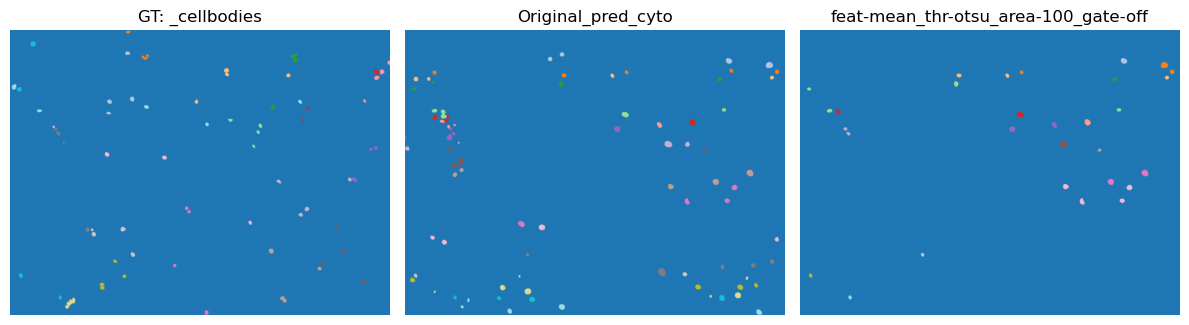

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
from pathlib import Path

# ---- FIXED ROOTS ----
CYTO_DIR = Path("/ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/cyto_prediction")
OUT_ROOT = CYTO_DIR.parent / "refilter_experiment_oct7"
GT_DIR   = Path("/ihome/jbwang/liy121/ifimage/00_dataset")

BASE_FILE = "olig2_12790_pred_cyto.npy"  # same name as in cyto_prediction

EXPERIMENT_SLUGS = [
    "feat-mean_thr-otsu_area-100_gate-off",
]

# ---- HELPERS ----
def core_from_pred_filename(fname: str) -> str:
    return Path(fname).stem.replace("_pred_cyto", "")

def load_mask(path: Path) -> np.ndarray:
    if path.suffix.lower() == ".npy":
        return np.load(path)
    return np.squeeze(tiff.imread(str(path)))

def find_gt_cellbodies(gt_root: Path, core: str) -> np.ndarray:
    pats = [f"{core}_cellbodies.npy", f"{core}_cellbodies.tif", f"{core}_cellbodies.tiff"]
    for p in pats:
        for f in gt_root.glob(p):
            return load_mask(f)
    raise FileNotFoundError(f"GT not found for {core}_cellbodies under {gt_root}")

# ---- LOAD ----
cyto_path = CYTO_DIR / BASE_FILE
assert cyto_path.exists(), f"missing {cyto_path}"
core = core_from_pred_filename(BASE_FILE)

gt = find_gt_cellbodies(GT_DIR, core)
orig_pred = load_mask(cyto_path)

masks = [orig_pred]
names = ["Original_pred_cyto"]

for slug in EXPERIMENT_SLUGS:
    p = OUT_ROOT / slug / BASE_FILE
    assert p.exists(), f"missing {p}"
    masks.append(load_mask(p))
    names.append(slug)

# ---- PLOT ----
fig, axes = plt.subplots(1, len(masks)+1, figsize=(4*(len(masks)+1), 4))
axes[0].imshow(gt, cmap="tab20")
axes[0].set_title("GT: _cellbodies")
axes[0].axis("off")

for i, (m, n) in enumerate(zip(masks, names), 1):
    axes[i].imshow(m, cmap="tab20")
    axes[i].set_title(n)
    axes[i].axis("off")

plt.tight_layout()
plt.show()


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
from pathlib import Path

# ---- FIXED ROOTS ----
CYTO_DIR = Path("/ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/cyto_prediction")
OUT_ROOT = CYTO_DIR.parent / "refilter_experiment_oct7"
GT_DIR   = Path("/ihome/jbwang/liy121/ifimage/00_dataset")

BASE_FILE = "olig2_12790_pred_cyto.npy"  # same name as in cyto_prediction

EXPERIMENT_SLUGS = [
    "feat-mean_thr-otsu_area-100_gate-off",
]

# ---- HELPERS ----
def core_from_pred_filename(fname: str) -> str:
    return Path(fname).stem.replace("_pred_cyto", "")

def load_mask(path: Path) -> np.ndarray:
    if path.suffix.lower() == ".npy":
        return np.load(path)
    return np.squeeze(tiff.imread(str(path)))

def first_match(root: Path, patterns: list[str]) -> Path | None:
    for p in patterns:
        for f in root.glob(p):
            return f
    return None

def find_gt_cellbodies(gt_root: Path, core: str) -> np.ndarray:
    pats = [f"{core}_cellbodies.npy", f"{core}_cellbodies.tif", f"{core}_cellbodies.tiff"]
    f = first_match(gt_root, pats)
    if f is None:
        raise FileNotFoundError(f"GT not found for {core}_cellbodies under {gt_root}")
    return load_mask(f)

def find_raw_channels(gt_root: Path, core: str) -> tuple[np.ndarray | None, np.ndarray | None]:
    # DAPI: {core}.tif|tiff|npy
    dapi_fp = first_match(gt_root, [f"{core}.tif", f"{core}.tiff", f"{core}.npy"])
    dapi = load_mask(dapi_fp) if dapi_fp else None

    # Marker: infer from leading token, else "_marker"
    leading = core.split("_", 1)[0].lower()
    marker_fp = first_match(
        gt_root,
        [f"{core}_{leading}.tif", f"{core}_{leading}.tiff", f"{core}_{leading}.npy",
         f"{core}_marker.tif", f"{core}_marker.tiff", f"{core}_marker.npy"]
    )
    marker = load_mask(marker_fp) if marker_fp else None

    return dapi, marker


def make_rgb(dapi: np.ndarray | None, marker: np.ndarray | None) -> np.ndarray | None:
    if dapi is None and marker is None:
        return None

    def to_gray(x: np.ndarray) -> np.ndarray:
        x = np.asarray(x)
        if x.ndim == 3:
            # H×W×C -> single channel
            if x.shape[-1] in (3, 4):
                # RGB(A) to luminance
                x = 0.2126*x[...,0] + 0.7152*x[...,1] + 0.0722*x[...,2]
            else:
                # treat as z/chan stack -> max-proj
                x = x.max(axis=-1)
        elif x.ndim > 2:
            x = x.squeeze()
            if x.ndim > 2:
                x = x.max(axis=0)
        return x.astype(np.float32)

    def norm(x: np.ndarray) -> np.ndarray:
        p1, p99 = np.percentile(x, [1, 99]) if x.size else (0, 1)
        if p99 <= p1:
            p1, p99 = float(x.min()), float(x.max()) if x.max() > x.min() else (0.0, 1.0)
        return np.clip((x - p1) / max(p99 - p1, 1e-6), 0, 1)

    d = to_gray(dapi)   if dapi   is not None else None
    m = to_gray(marker) if marker is not None else None

    # align shapes by safe crop to common min size
    if d is not None and m is not None:
        h = min(d.shape[0], m.shape[0])
        w = min(d.shape[1], m.shape[1])
        d, m = d[:h, :w], m[:h, :w]
        H, W = h, w
    else:
        base = d if d is not None else m
        H, W = base.shape

    rgb = np.zeros((H, W, 3), dtype=np.float32)
    if d is not None: rgb[..., 2] = norm(d)  # DAPI -> Blue
    if m is not None: rgb[..., 1] = norm(m)  # Marker -> Green
    return rgb


# ---- LOAD ----
cyto_path = CYTO_DIR / BASE_FILE
assert cyto_path.exists(), f"missing {cyto_path}"
core = core_from_pred_filename(BASE_FILE)

gt = find_gt_cellbodies(GT_DIR, core)
orig_pred = load_mask(cyto_path)

dapi, marker = find_raw_channels(GT_DIR, core)
raw_rgb = make_rgb(dapi, marker)

masks = [orig_pred]
names = ["Original_pred_cyto"]

for slug in EXPERIMENT_SLUGS:
    p = OUT_ROOT / slug / BASE_FILE
    assert p.exists(), f"missing {p}"
    masks.append(load_mask(p))
    names.append(slug)

# ---- FIGURE LAYOUT: [GT, RawRGB, Original, ...experiments] ----
n_panels = 2 + len(masks)  # GT + Raw + masks
fig, axes = plt.subplots(1, n_panels, figsize=(4*n_panels, 4))

# GT
axes[0].imshow(gt, cmap="tab20")
axes[0].set_title("GT: _cellbodies")
axes[0].axis("off")

# Raw RGB
if raw_rgb is not None:
    axes[1].imshow(raw_rgb)
    axes[1].set_title("Raw: DAPI+Marker")
else:
    axes[1].text(0.5, 0.5, "Raw channels not found", ha="center", va="center")
    axes[1].set_title("Raw: missing")
axes[1].axis("off")

# Predictions
for i, (m, n) in enumerate(zip(masks, names), start=2):
    axes[i].imshow(m, cmap="tab20")
    axes[i].set_title(n)
    axes[i].axis("off")

plt.tight_layout()

# ---- SAVE ----
fig_dir = OUT_ROOT / "figs"
fig_dir.mkdir(parents=True, exist_ok=True)
out_path = fig_dir / f"{core}.png"
plt.savefig(out_path, dpi=200)
plt.close(fig)

print(f"Saved figure -> {out_path}")


Saved figure -> /ihome/jbwang/liy121/ifimage/01_cellpose_benchmark/refilter_experiment_oct7/figs/olig2_12790.png
